In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from scipy.stats import pearsonr, kruskal, chi2_contingency
from statsmodels.tsa.stattools import grangercausalitytests, adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import datetime
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from collections import defaultdict


bike_df = pd.read_csv('./files/bike_dataset_clean.csv')
bike_df.drop(columns='Unnamed: 0', inplace=True)

# check what the correlation between the different temperature features and total_cust is
# maybe I could just use one of the other temperature features instead of temp_avg

# correlation between temp_avg and total_cust
# The first 820 rows are excluded because they contain missing temp_avg values
print('temp_avg:', pearsonr(bike_df['temp_avg'][821:], bike_df['total_cust'][821:]), '\n')

# correlation between temp_min and total_cust
print('temp_min:', pearsonr(bike_df['temp_min'], bike_df['total_cust']))
print('temp_min, without first 820 rows:', pearsonr(bike_df['temp_min'][821:], bike_df['total_cust'][821:]), '\n')

# correlation between temp_max and total_cust
print('temp_max:', pearsonr(bike_df['temp_max'], bike_df['total_cust']))
print('temp_max, without first 820 rows:', pearsonr(bike_df['temp_max'][821:], bike_df['total_cust'][821:]), '\n')

# correlation between temp_observ and total_cust
print('temp_observ:', pearsonr(bike_df['temp_observ'], bike_df['total_cust']))
print('temp_observ, without first 820 rows:', pearsonr(bike_df['temp_observ'][821:], bike_df['total_cust'][821:]), '\n')

temp_avg: PearsonRResult(statistic=0.7289653483071338, pvalue=0.0) 

temp_min: PearsonRResult(statistic=0.5484063784007367, pvalue=3.92265728990609e-229)
temp_min, without first 820 rows: PearsonRResult(statistic=0.6720561174778342, pvalue=3.5204893405440216e-276) 

temp_max: PearsonRResult(statistic=0.5962507437902363, pvalue=6.986689659232709e-281)
temp_max, without first 820 rows: PearsonRResult(statistic=0.7406902128448435, pvalue=0.0) 

temp_observ: PearsonRResult(statistic=0.5500110613450737, pvalue=9.817169026462281e-231)
temp_observ, without first 820 rows: PearsonRResult(statistic=0.6804926361142358, pvalue=9.041087867799183e-286) 



In [2]:
# calculating the Granger causality between the temperature feats and the target
print('Average temperature and target:')
grangercausalitytests(bike_df[['total_cust', 'temp_avg']][821:], maxlag=1);
print('\nMaximum temperature and target:')
grangercausalitytests(bike_df[['total_cust', 'temp_max']], maxlag=1);
print('\nMinimum temperature and target:')
grangercausalitytests(bike_df[['total_cust', 'temp_min']], maxlag=1);
print('\nObserved temperature and target:')
grangercausalitytests(bike_df[['total_cust', 'temp_observ']], maxlag=1);

Average temperature and target:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=176.4496, p=0.0000  , df_denom=2097, df_num=1
ssr based chi2 test:   chi2=176.7020, p=0.0000  , df=1
likelihood ratio test: chi2=169.6602, p=0.0000  , df=1
parameter F test:         F=176.4496, p=0.0000  , df_denom=2097, df_num=1

Maximum temperature and target:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=40.0233 , p=0.0000  , df_denom=2918, df_num=1
ssr based chi2 test:   chi2=40.0645 , p=0.0000  , df=1
likelihood ratio test: chi2=39.7922 , p=0.0000  , df=1
parameter F test:         F=40.0233 , p=0.0000  , df_denom=2918, df_num=1

Minimum temperature and target:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=88.8911 , p=0.0000  , df_denom=2918, df_num=1
ssr based chi2 test:   chi2=88.9825 , p=0.0000  , df=1
likelihood ratio test: chi2=87.6540 , p=0.0000  , df=1
parameter F test:         F=88.8911 , p=0.0000  , df_denom=2918,

In [3]:
# function to create seasons for dataframe
def seasons(df):
    '''
    Function to create new features for seasons based on months
    Args: df = dataframe
    Returns: df = dataframe
    '''

    #create a season features
    df['season_spring'] = df['date'].apply(lambda x: 1 if '01' in x[5:7] else 1 if '02' in x[5:7] else 1
                                                        if '03' in x[5:7] else 0)
    df['season_summer'] = df['date'].apply(lambda x: 1 if '04' in x[5:7] else 1 if '05' in x[5:7] else 1
                                                        if '06' in x[5:7] else 0)
    df['season_fall'] = df['date'].apply(lambda x: 1 if '07' in x[5:7] else 1 if '08' in x[5:7] else 1
                                                        if '09' in x[5:7] else 0)
    return df


In [4]:
# create new features for season
bike_df = seasons(bike_df)

# create new feature weekday
bike_df['date_datetime'] = bike_df['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
bike_df['weekday'] = bike_df['date_datetime'].apply(lambda x: x.weekday())

# one hot encode the feature weekday
weekday_dummies = pd.get_dummies(bike_df['weekday'], prefix = 'weekday', drop_first=True)
bike_df = bike_df.join(weekday_dummies, how='left')
bike_df.head()

,date,temp_avg,temp_min,temp_max,temp_observ,precip,wind,wt_fog,wt_heavy_fog,wt_thunder,...,season_summer,season_fall,date_datetime,weekday,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,2011-01-01,NaN,-1.566667,11.973333,2.772727,0.069333,2.575,1.0,0.0,0.0,...,0,0,2011-01-01,5,0,0,0,0,1,0
1,2011-01-02,NaN,0.880000,13.806667,7.327273,1.037349,3.925,1.0,1.0,0.0,...,0,0,2011-01-02,6,0,0,0,0,0,1
2,2011-01-03,NaN,-3.442857,7.464286,-3.060000,1.878824,3.625,0.0,0.0,0.0,...,0,0,2011-01-03,0,0,0,0,0,0,0
3,2011-01-04,NaN,-5.957143,4.642857,-3.100000,0.000000,1.800,0.0,0.0,0.0,...,0,0,2011-01-04,1,1,0,0,0,0,0
4,2011-01-05,NaN,-4.293333,6.113333,-1.772727,0.000000,2.950,0.0,0.0,0.0,...,0,0,2011-01-05,2,0,1,0,0,0,0


In [5]:
#create new feature working_day
bike_df['working_day'] = bike_df['weekday'].apply(lambda x: 0 if x > 5 or x == 0 else 1)
bike_df['working_day'] = bike_df[['holiday', 'working_day']].apply( lambda x: 0 if x['holiday'] ==1 else
                                                                x['working_day'], axis=1)
#dropping date, registered and casual features because  this is in string format
bike_df.drop(columns=['date', 'temp_avg', 'registered', 'casual'], inplace=True)

Text(0, 0.5, 'Number of customers')

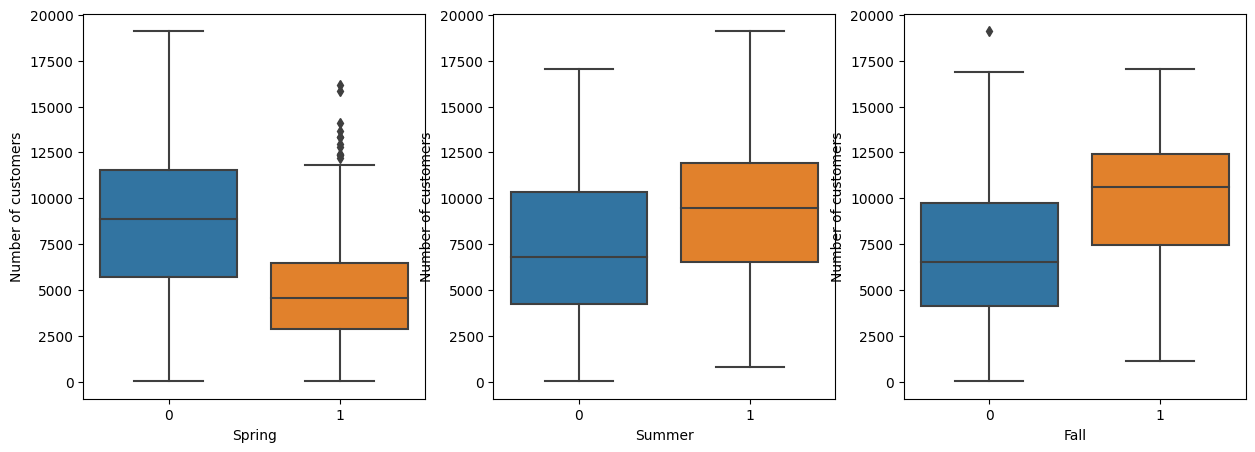

In [6]:
# Explorartory Data Analysis of Categorical Variables

# varialbe to be used below to iterate through the columns and plot them
season_names = ['season_spring', 'season_summer', 'season_fall']
# plot boxplots for season versus number of users
plt.figure(figsize = [15,5])

# boxplot for feature workingday
# spring
plt.subplot(1,3,1)
sb.boxplot(data=bike_df, x='season_spring', y='total_cust')
plt.xlabel('Spring')
plt.ylabel('Number of customers')

# boxplot for feature weekday
# summer
plt.subplot(1,3,2)
sb.boxplot(data=bike_df, x='season_summer',y='total_cust')
plt.xlabel('Summer')
plt.ylabel('Number of customers')

# boxplot for feature holiday
# fall
plt.subplot(1,3,3)
sb.boxplot(data=bike_df, x='season_fall',y='total_cust')
plt.xlabel('Fall')
plt.ylabel('Number of customers')

# these plots do not compare workingday vs weekday vs holiday! The are showing total customers across the seasons.

In [7]:
 #Correlation between seaon features and the maximum temperature using the
# Kruskal Wallis H test for correlation between a continuous and categorical variable
kruskal(bike_df['temp_max'], bike_df['season_summer'])

KruskalResult(statistic=4190.233791908425, pvalue=0.0)

<AxesSubplot: xlabel='holiday', ylabel='total_cust'>

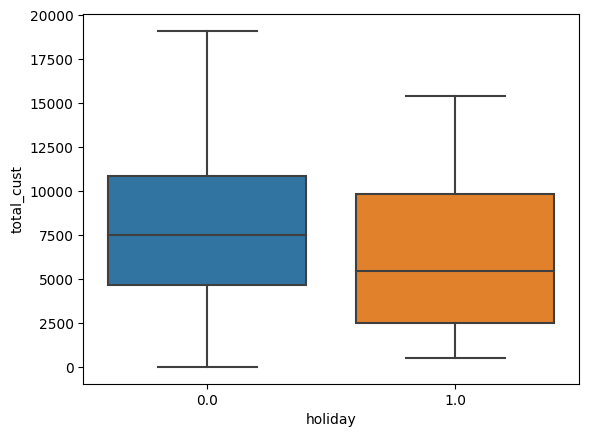

In [8]:
# plotting the customer statistics in form of a boxplot for the holiday feature
sb.boxplot(data=bike_df, x='holiday', y='total_cust')

In [9]:
# Correlation between holiday feature and the number of customers poer day using the
# Kurskal Wallis H test for correlations between a contiuous and categorical variable
kruskal(bike_df['holiday'], bike_df['total_cust'])

KruskalResult(statistic=4945.69275502358, pvalue=0.0)

Text(0, 0.5, 'Number of customers')

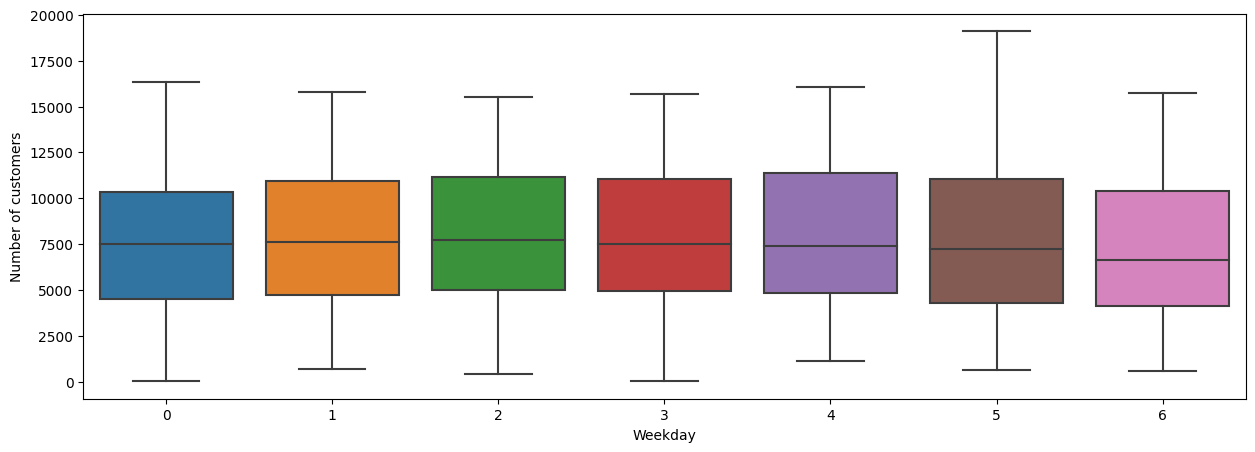

In [10]:
# plotting the customer statistics in form of a boxplot for the weekday feature
plt.figure(figsize=[15,5])
sb.boxplot(data=bike_df, x='weekday', y='total_cust')
plt.xlabel('Weekday')
plt.ylabel('Number of customers')

In [11]:
# Correlation between weekday feature and the number of customers per day using Pearson's correlation coefficient
# assuming that a weekday can be considered a continuous variable.
pearsonr(bike_df['weekday'], bike_df['total_cust'])

PearsonRResult(statistic=-0.024760898572408853, pvalue=0.18086518739719304)

Text(0, 0.5, 'Number of customers')

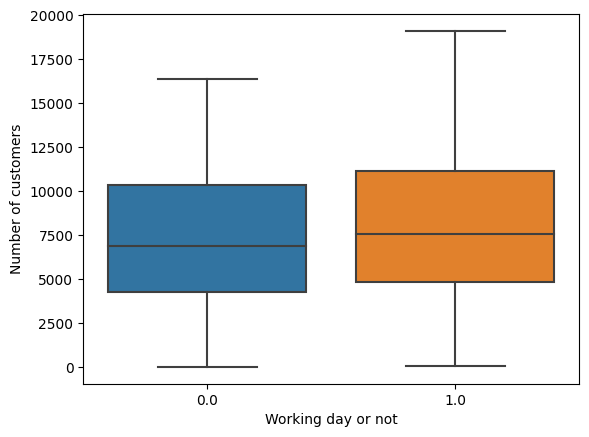

In [12]:
# plotting workday feature in boxplot against the count of customers
sb.boxplot(data = bike_df, x='working_day',y='total_cust')
plt.xlabel('Working day or not')
plt.ylabel('Number of customers')

In [13]:
# Correlation between working_day feature and the number of customers per day using the Kurskal Wallis H test
# for correlations between a continous and categorical variable
kruskal(bike_df['working_day'], bike_df['total_cust'])

KruskalResult(statistic=4596.399701396863, pvalue=0.0)

<AxesSubplot: xlabel='holiday', ylabel='total_cust'>

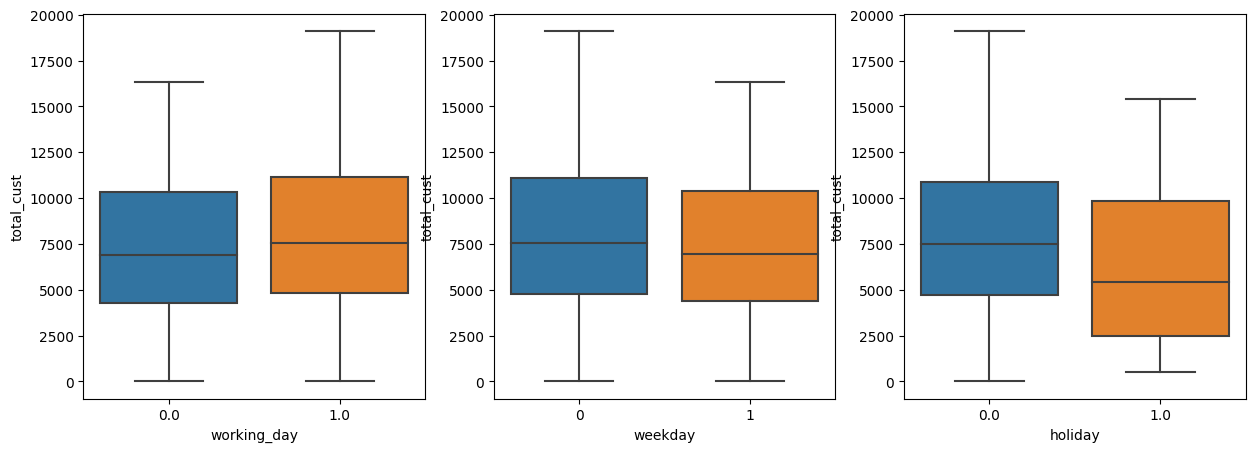

In [14]:
# Creating a new dataframe that encodes the weekday feature with 0 for monday through friday and 
# 1 for saturday and sunday
weekend_distinct_df= bike_df.copy()
weekend_distinct_df['weekday'] = weekend_distinct_df['weekday'].apply(lambda x: 1 if (x == 6 or x == 0) else 0)

#plot boxplots for comparison between the weekday and workingday feature
plt.figure(figsize=[15,5])
#boxplot for feature workingday
plt.subplot(1,3,1)
sb.boxplot(data=bike_df, x='working_day', y='total_cust')
#boxplot for feature weekday
plt.subplot(1,3,2)
sb.boxplot(data=weekend_distinct_df, x='weekday',y='total_cust')
#boxplot for feature holiday
plt.subplot(1,3,3)
sb.boxplot(data=bike_df, x='holiday',y='total_cust')

In [15]:
#means of each instance of workingday
bike_df.groupby('working_day')['total_cust'].mean()

working_day
0.0    7262.673563
1.0    7913.302144
Name: total_cust, dtype: float64

In [16]:
# means of each instance of weekday
weekend_distinct_df.groupby('weekday')['total_cust'].mean()

weekday
0    7878.716203
1    7322.511962
Name: total_cust, dtype: float64

In [17]:
# means of each instance of holiday
bike_df.groupby('holiday')['total_cust'].mean()

holiday
0.0    7771.698200
1.0    6060.685393
Name: total_cust, dtype: float64

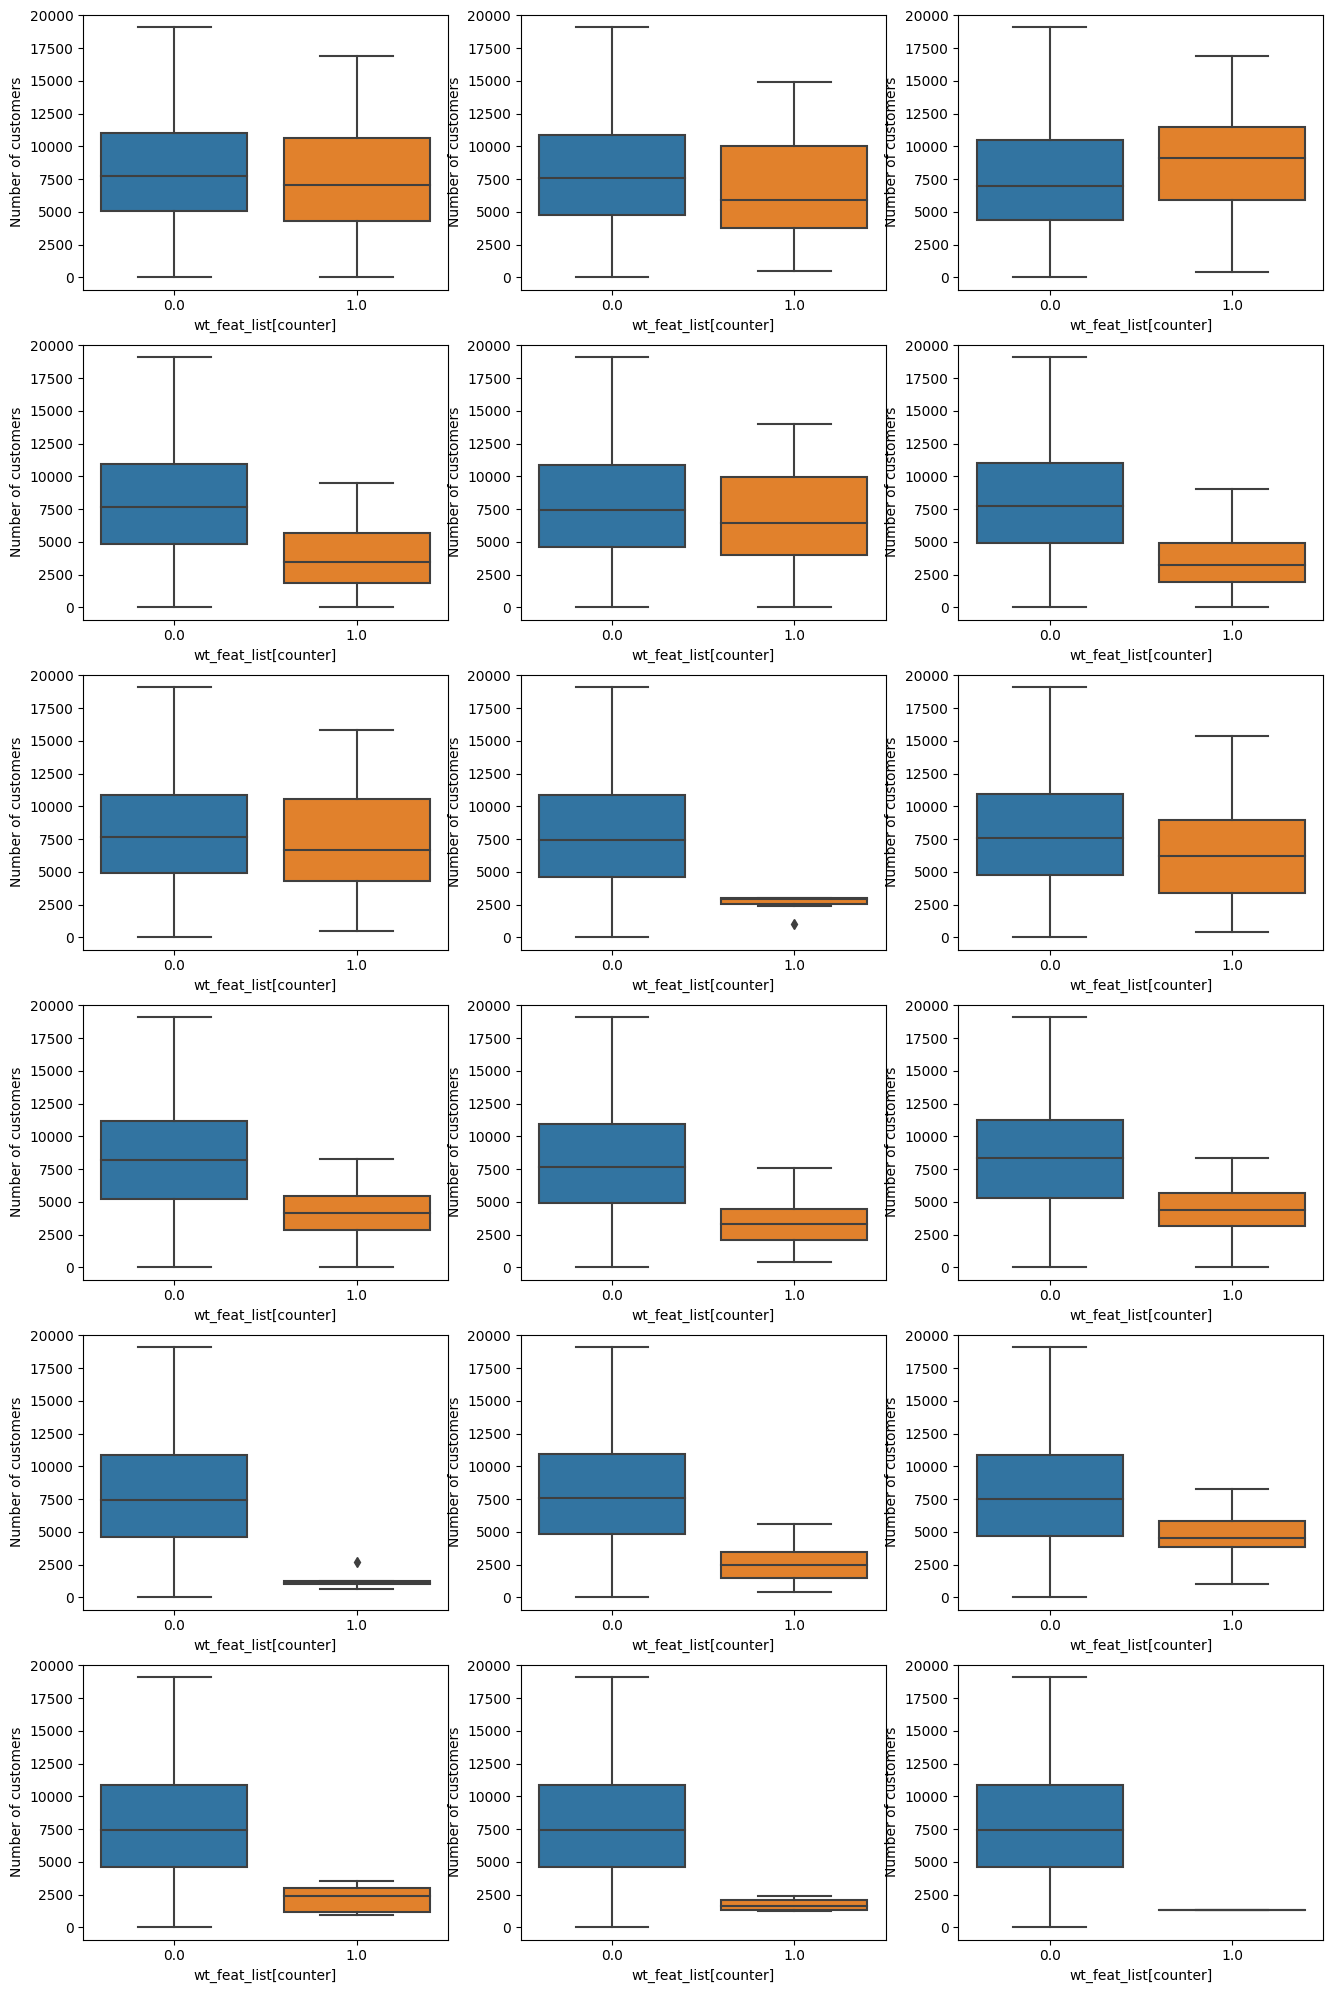

In [18]:
# plotting the revenue of the most common production companies vs. the rest
fig, ax = plt.subplots(6,3,figsize = [16,25])

#create list with all feature names
wt_feat_list = [x for x in bike_df.columns if 'wt_' in x]

#company counter
counter = 0

for j in range(len(ax)):
    for i in range(len(ax[j])):
        if j == 5 and i == 3:
            break
        else:
            ax[j][i] = sb.boxplot(data=bike_df, x = wt_feat_list[counter], y='total_cust',ax=ax[j][i])
            ax[j][i].set_ylabel('Number of customers')
            ax[j][i].set_xlabel('wt_feat_list[counter]')
            counter += 1

In [19]:
# consolidating similar weather types into new features(columns)
#fog, heavy fog, hail, haze, high wind
bike_df['foggy'] = bike_df['wt_fog'] + bike_df['wt_heavy_fog'] + bike_df['wt_hail'] + bike_df['wt_haze'] + bike_df['wt_high_wind']
bike_df['foggy'] = bike_df['foggy'].apply(lambda x : 0 if x == 0 else 1)

#thunder
bike_df['thunder'] = bike_df['wt_thunder']

# ice_fog, unknown, freeze_drizzle, freeze_rain, drift_snow
bike_df['ice'] = bike_df['wt_ice_fog'] + bike_df['wt_unknown'] + bike_df['wt_freeze_drizzle'] + bike_df['wt_freeze_rain'] + bike_df['wt_drift_snow']
bike_df['ice'] = bike_df['ice'].apply(lambda x: 0 if x == 0 else 1)

# sleet, glaze, snow
bike_df['sleet'] = bike_df['wt_sleet'] + bike_df['wt_glaze'] + bike_df['wt_snow']
bike_df['sleet'] = bike_df['sleet'].apply(lambda x: 0 if x == 0 else 1)

# mist, drizzle, rain, ground fog
bike_df['rain'] = bike_df['wt_mist'] + bike_df['wt_drizzle'] + bike_df['wt_rain'] + bike_df['wt_ground_fog']
bike_df['rain'] = bike_df['rain'].apply(lambda x: 0 if x == 0 else 1)

bike_df.drop(columns=wt_feat_list, inplace=True)


Text(0, 0.5, 'Number of customers')

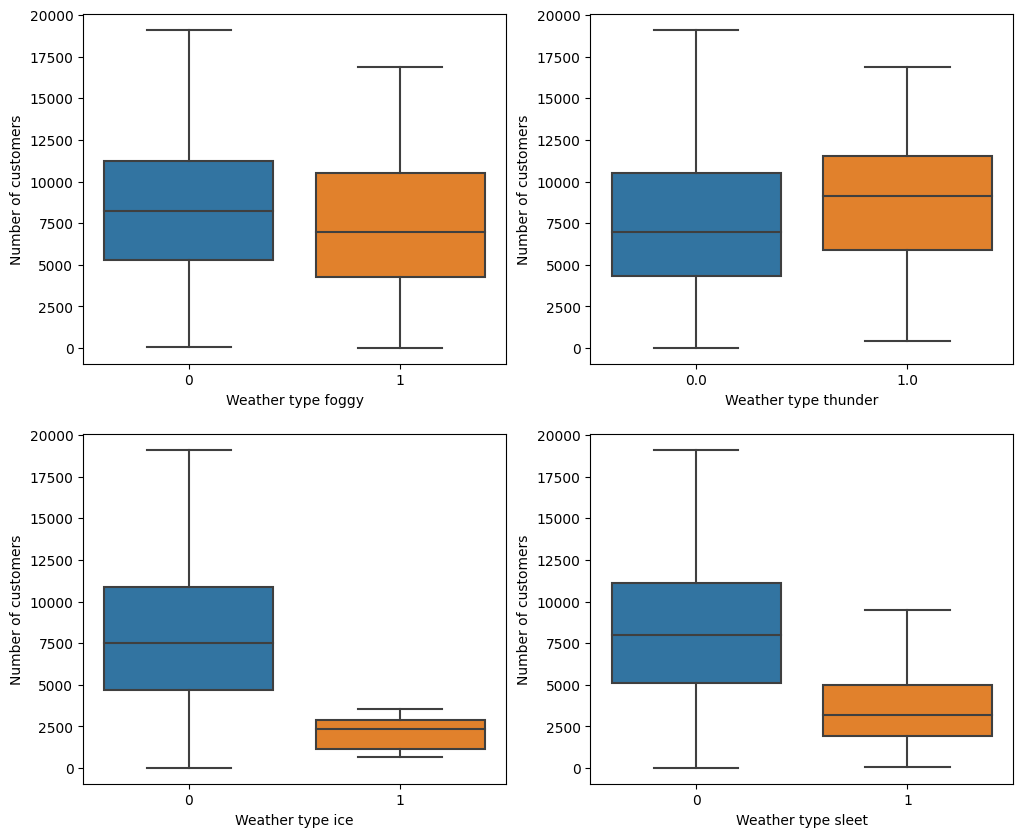

In [20]:
# boxplot comparison for condensed weather type features and target

plt.figure(figsize = [12, 10])

# boxplot for foggy feature
plt.subplot(2,2,1)
sb.boxplot(data = bike_df, x = 'foggy', y = 'total_cust')
plt.xlabel('Weather type foggy')
plt.ylabel('Number of customers')

# boxplot for thunder feature
plt.subplot(2,2,2)
sb.boxplot(data = bike_df, x = 'thunder', y = 'total_cust')
plt.xlabel('Weather type thunder')
plt.ylabel('Number of customers')

# boxplot for ice feature
plt.subplot(2,2,3)
sb.boxplot(data = bike_df, x = 'ice', y = 'total_cust')
plt.xlabel('Weather type ice')
plt.ylabel('Number of customers')

# boxplt for sleet feature
plt.subplot(2,2,4)
sb.boxplot(data = bike_df, x = 'sleet', y = 'total_cust')
plt.xlabel('Weather type sleet')
plt.ylabel('Number of customers')

<Figure size 1500x600 with 0 Axes>

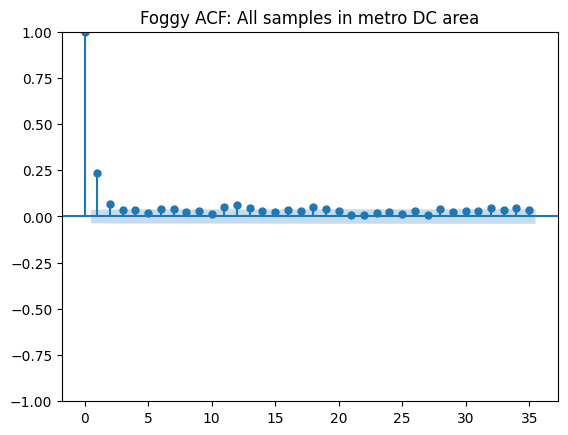

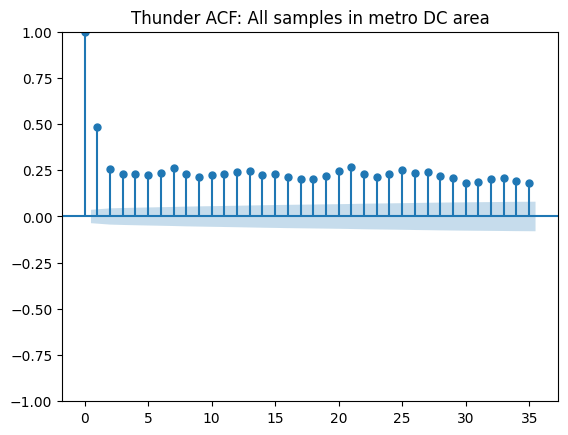

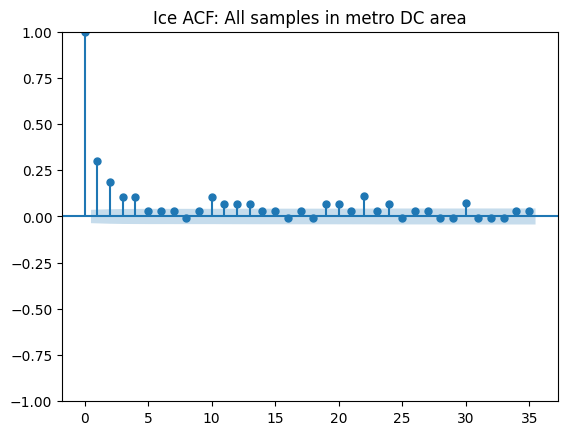

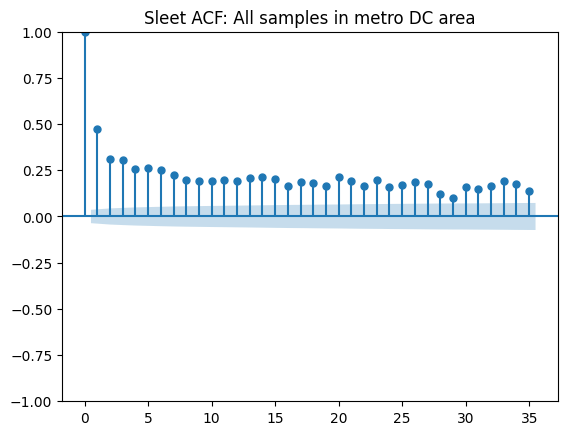

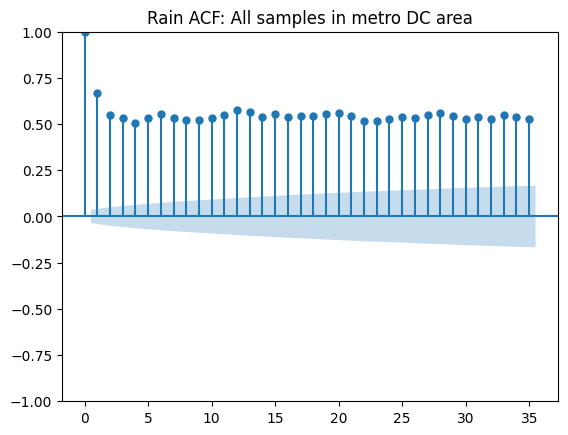

In [21]:
# plotting the autocorrelation function of condensed wt_features
plt.figure(figsize=[15,6])

plot_acf(bike_df['foggy'], title='Foggy ACF: All samples in metro DC area',)
plt.show()

plot_acf(bike_df['thunder'], title='Thunder ACF: All samples in metro DC area',)
plt.show()

plot_acf(bike_df['ice'], title='Ice ACF: All samples in metro DC area',)
plt.show()

plot_acf(bike_df['sleet'], title='Sleet ACF: All samples in metro DC area',)
plt.show()

plot_acf(bike_df['rain'], title='Rain ACF: All samples in metro DC area',)
plt.show()

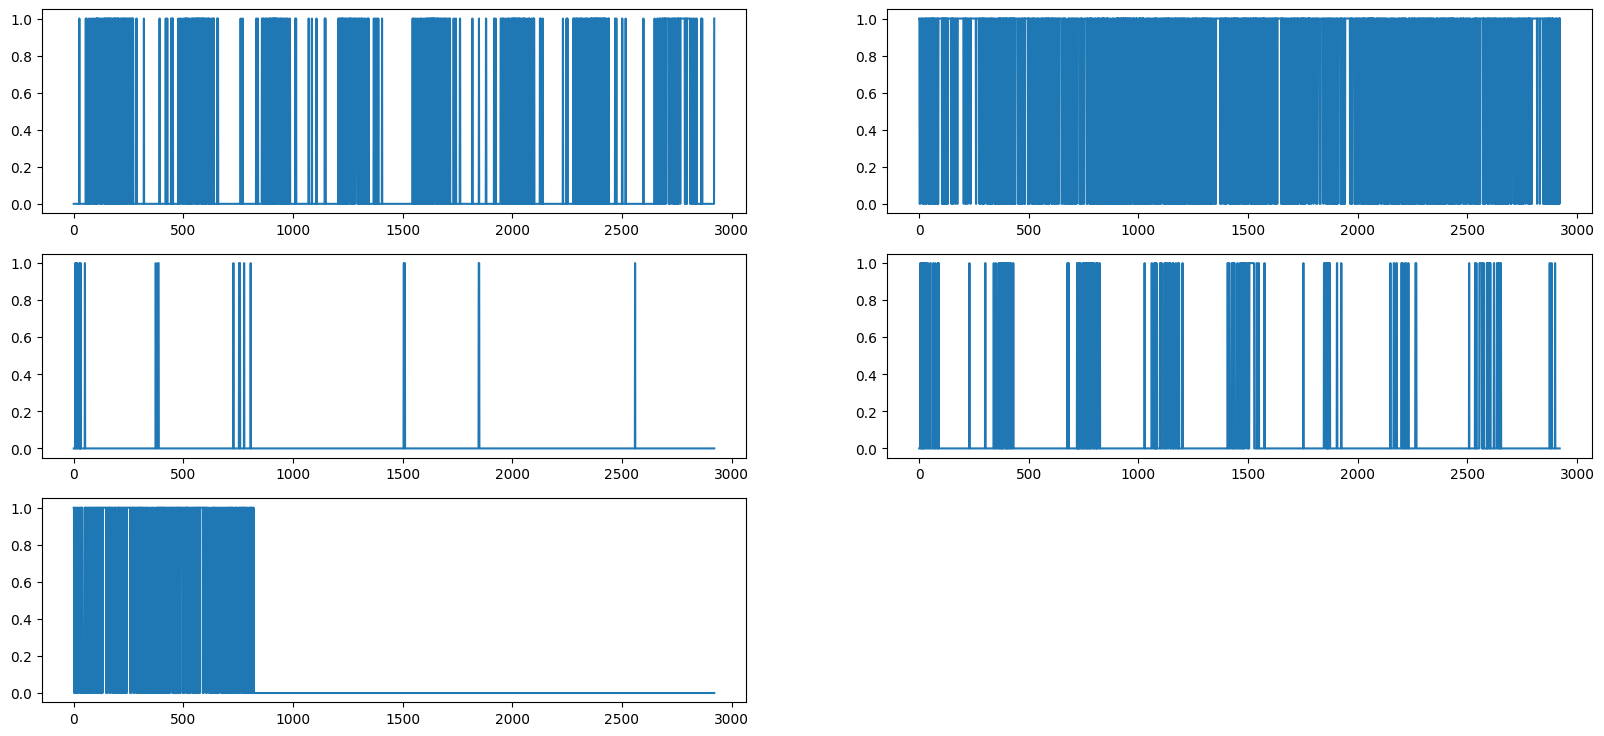

In [22]:


# plotting condensed weather features
plt.figure(figsize=[20,9])

plt.subplot(3,2,1)
plt.plot(bike_df['thunder'])

plt.subplot(3, 2, 2)
plt.plot(bike_df['foggy'])

plt.subplot(3, 2, 3)
plt.plot(bike_df['ice'])

plt.subplot(3, 2, 4)
plt.plot(bike_df['sleet'])

plt.subplot(3, 2, 5)
plt.plot(bike_df['rain'])

In [23]:
# rain feature data collection discontinued after 2 years
bike_df.drop(columns=['rain'], inplace=True)

# list for all rolling sums between weather feature and target
def best_window_sum(x, y, max_window):
    corr_temp_cust = []
    for i in range(1, max_window):
        roll_val = list(x.rolling(i).sum()[i-1:-1])
        total_cust_ti = list(y[i:])
        corr, p_val = pearsonr(total_cust_ti, roll_val)
        corr_temp_cust.append(corr)
    # get the optimal window size for rolling mean
    max_val = np.argmax(corr_temp_cust)
    min_val = np.argmin(corr_temp_cust)
    opt_corr_min = corr_temp_cust[min_val]
    opt_corr_max = corr_temp_cust[max_val]
    
    results = {max_val+1: opt_corr_max, min_val+1: opt_corr_min}
    
    return results

In [24]:
# optimal window for rolling sum for foggy
print(best_window_sum(bike_df['foggy'], bike_df['total_cust'], 30))

# correlation for window size determined by foggy
foggy_mean = bike_df['foggy'].rolling(8).sum()[7:-1]
pearsonr(foggy_mean, bike_df['total_cust'][8:])

{3: -0.03454117565250649, 29: -0.08701177677103925}


PearsonRResult(statistic=-0.056992243357476005, pvalue=0.0020859976421017255)

In [25]:
# optimal window for rolling sum for thunder
print(best_window_sum(bike_df['thunder'], bike_df['total_cust'], 30))

# correlation for window size determined by thunder
thunder_mean = bike_df['thunder'].rolling(8).sum()[7:-1]
pearsonr(thunder_mean, bike_df['total_cust'][8:])

{29: 0.4348951971254514, 1: 0.21740383154927378}


PearsonRResult(statistic=0.3589870088310652, pvalue=2.3622036013534496e-89)

In [26]:
#optimal window for rolling sum for sleet
print(best_window_sum(bike_df['sleet'], bike_df['total_cust'], 30))

# correlationn for window size determined by sleet
sleet_mean = bike_df['sleet'].rolling(8).sum()[7:-1]
pearsonr(sleet_mean, bike_df['total_cust'][8:])


{1: -0.30643580747310273, 21: -0.43628302776959116}


PearsonRResult(statistic=-0.4032156282343481, pvalue=2.32726408555059e-114)

Text(158.08159722222223, 0.5, 'Columns')

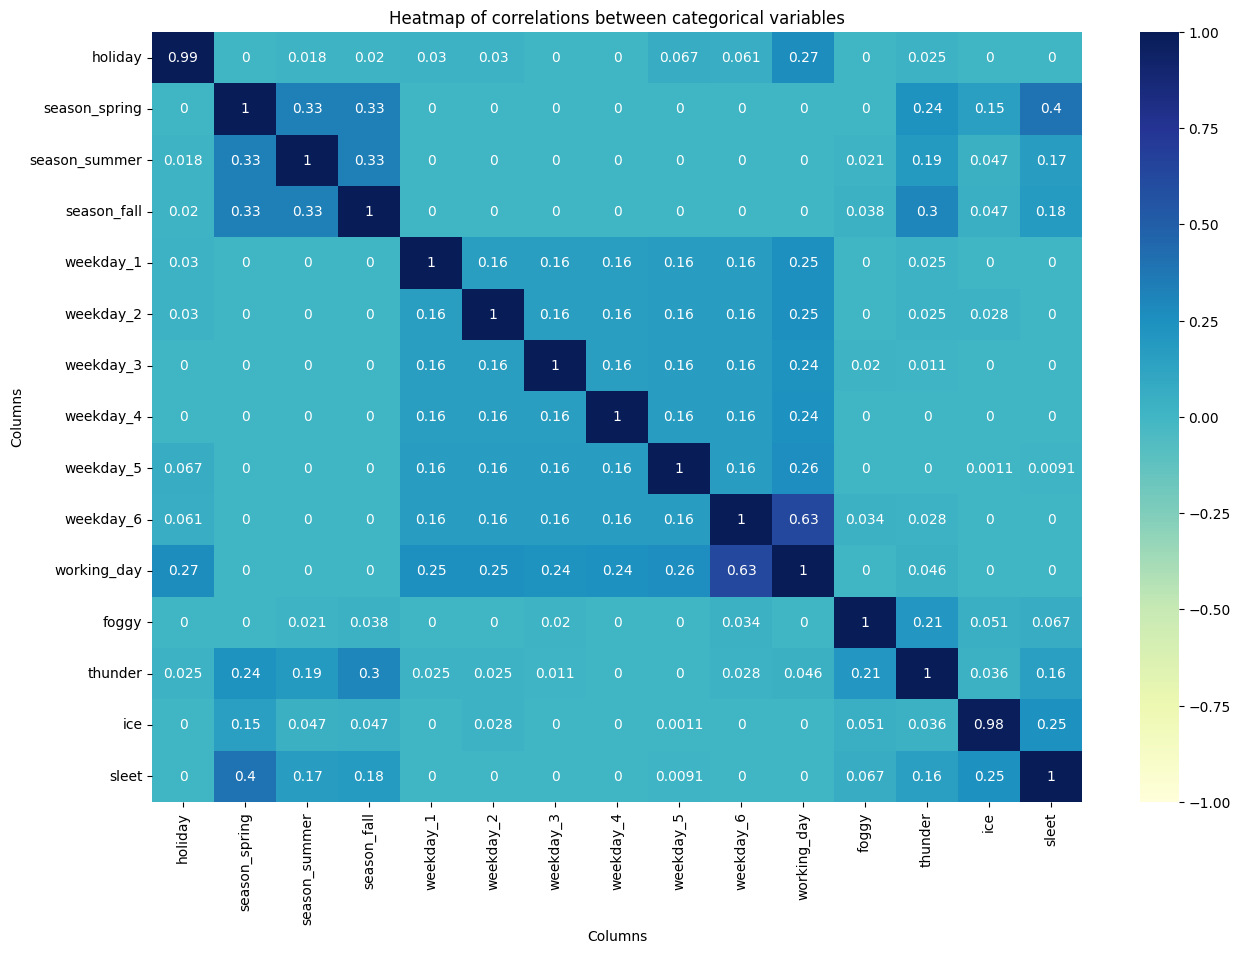

In [27]:
# drop any non-categorical variables
bike_df_corr_cat= bike_df.drop(columns=['date_datetime', 'weekday', 'temp_min', 'temp_max', 'temp_observ', 'precip', 'wind', 'total_cust'], axis = 1)

# from https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
def cramers_v(x,y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0,phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1), (rcorr-1)))

# correlation matrix with cramer's V coefficients
corr_matrix = pd.DataFrame(data = None, index=np.arange(len(bike_df_corr_cat.columns)), columns = bike_df_corr_cat.columns)
for col in bike_df_corr_cat.columns:
    count = 0
    for val in bike_df_corr_cat.columns:
        corr_cat = cramers_v(bike_df_corr_cat[col], bike_df_corr_cat[val])
        corr_matrix[col][count] = corr_cat
        count += 1
    corr_matrix = corr_matrix.astype('float')

#add index to the dataframe
corr_matrix['columns']= bike_df_corr_cat.columns
corr_matrix.set_index('columns', inplace=True)

#plot a heatmap for correlations beween categorical variables
plt.figure(figsize=[15,10])
sb.heatmap(corr_matrix, annot=True, vmin=-1, vmax=1, center=0,fmt='.2g', cmap='YlGnBu')
plt.title('Heatmap of correlations between categorical variables')
plt.xlabel('Columns')
plt.ylabel('Columns')



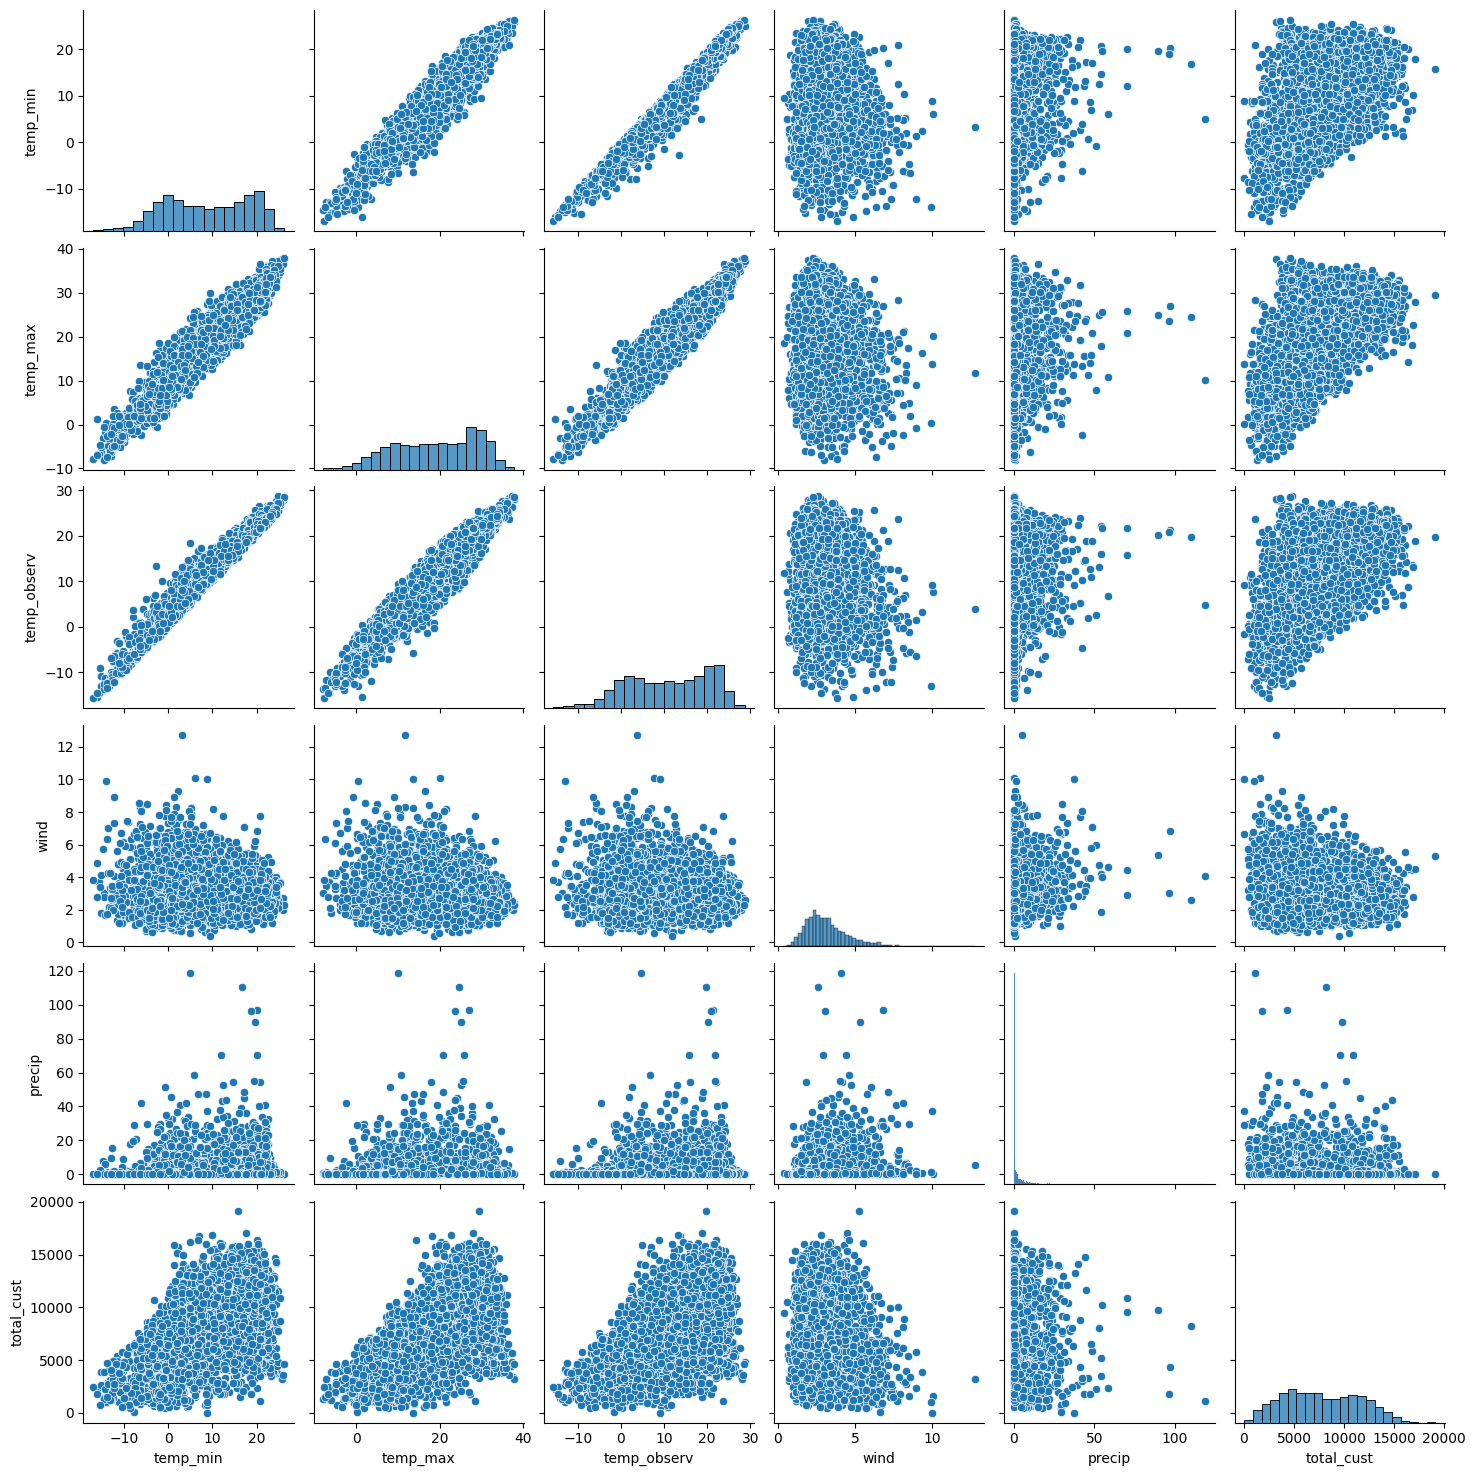

In [28]:
# distribution and scatterplot between each continuos varable pair
sb.pairplot(bike_df, vars=['temp_min', 'temp_max', 'temp_observ', 'wind', 'precip', 'total_cust'])

Text(95.58159722222221, 0.5, 'Columns')

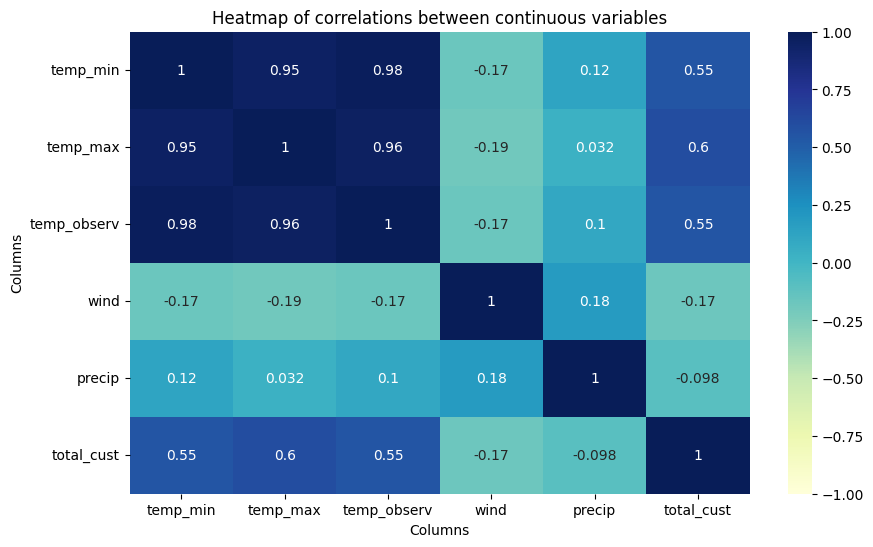

In [29]:
# correlation matrix
bike_df_corr = bike_df[['temp_min', 'temp_max', 'temp_observ', 'wind', 'precip', 'total_cust']].corr()

# create a heatmap to visualize the results
plt.figure(figsize=[10,6])
sb.heatmap(bike_df_corr, annot=True, vmin=-1, vmax=1, center=0, cmap='YlGnBu')
plt.title('Heatmap of correlations between continuous variables')
plt.xlabel('Columns')
plt.ylabel('Columns')

In [30]:
# get list for all correlations betwen a feature and total_cust with different rolling means
def best_window(x,y, max_window):
    corr_temp_cust = []
    for i in range(1, max_window):
        roll_val = list(x.rolling(i).mean()[i-1:-1])
        total_cust_ti = list(y[i:])
        corr, p_val = pearsonr(total_cust_ti, roll_val)
        corr_temp_cust.append(corr)
    
    # get the optimal window size for rolling mean between a feature and total_cust
    max_val = np.argmax(corr_temp_cust)
    min_val = np.argmin(corr_temp_cust)
    opt_corr_min = corr_temp_cust[min_val]
    opt_corr_max = corr_temp_cust[max_val]
    
    results = {max_val + 1: opt_corr_max, min_val + 1: opt_corr_min}
    return results

# get list for all correlations between a feature and total_cust with different rolling std_dev
def best_window_std(x, y, max_window):
    corr_temp_cust = []
    for i in range(2, max_window):
        roll_val = list(x.rolling(i).std()[i-1:-1])
        total_cust_ti = list(y[i:])
        corr, p_val = pearsonr(total_cust_ti, roll_val)
        corr_temp_cust.append(corr)
    
    # get the optimal window size for rolling std dev between a feature and total_cust
    max_val = np.argmax(corr_temp_cust)
    min_val = np.argmin(corr_temp_cust)
    opt_corr_min = corr_temp_cust[min_val]
    opt_corr_max = corr_temp_cust[max_val]

    results = {max_val + 1: opt_corr_max, min_val + 1: opt_corr_min}
    return results


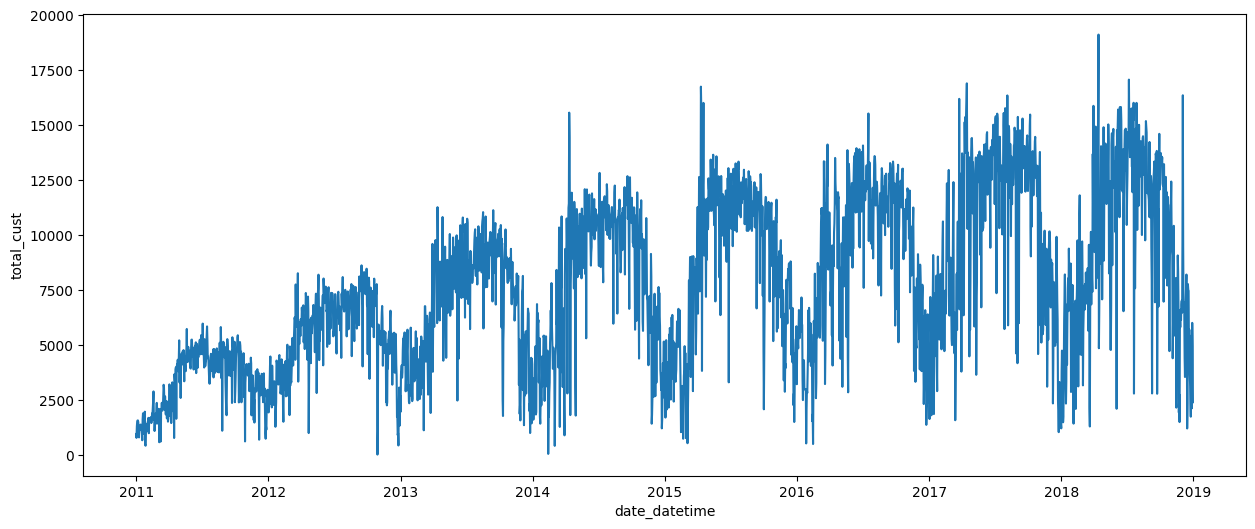

In [31]:
# plot the overall total_cust values for entire timeseries
plt.figure(figsize=[15,6])
ax = sb.lineplot(x='date_datetime', y='total_cust', data=bike_df)

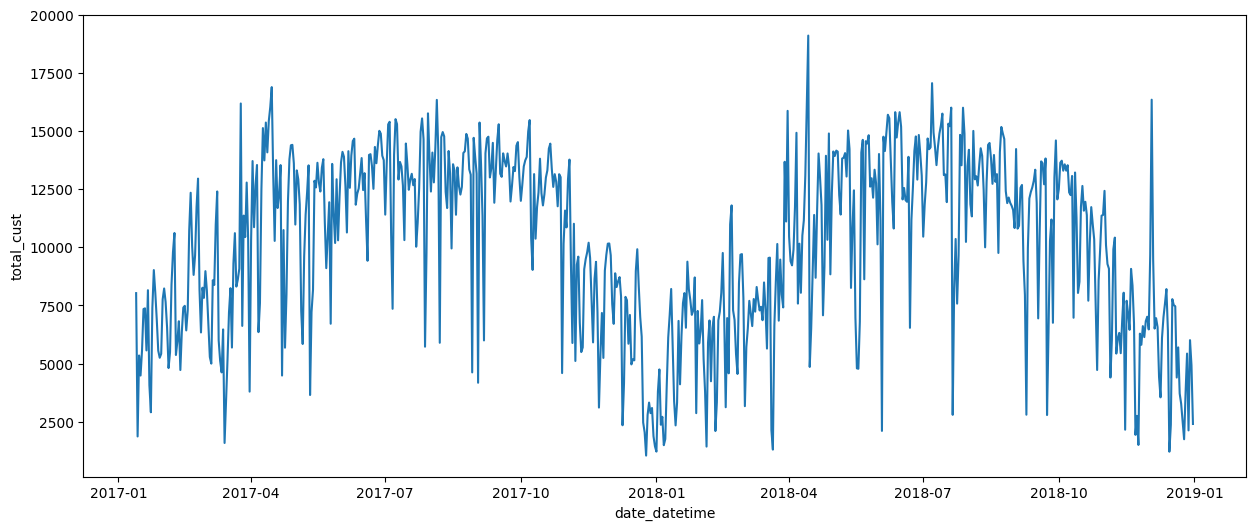

In [32]:
# plotting the last two years of timeseries data
plt.figure(figsize=[15,6])
ax = sb.lineplot(x='date_datetime', y='total_cust',data=bike_df[-718:])

/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<function matplotlib.pyplot.show(close=None, block=None)>

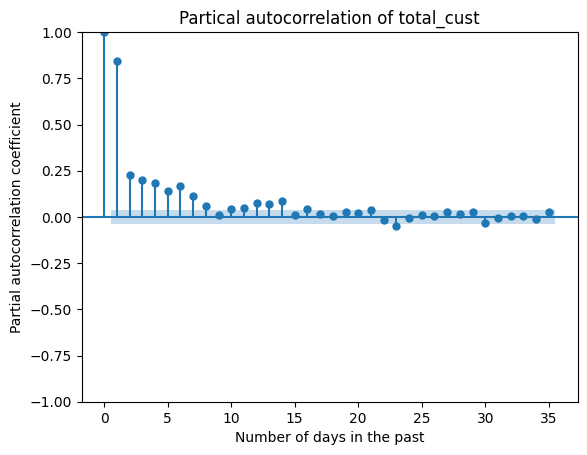

In [33]:
# plotting the partial autocorrelation for total_cust
plot_pacf(bike_df['total_cust'], title='Partical autocorrelation of total_cust',)
plt.xlabel('Number of days in the past')
plt.ylabel('Partial autocorrelation coefficient')
plt.show


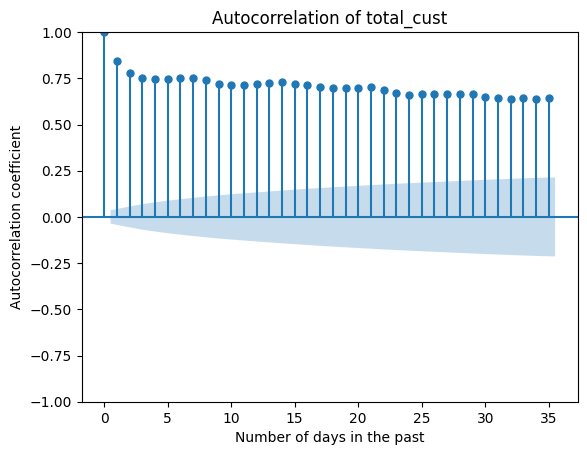

In [34]:
# plotting the autocorrelation for total_cust
plot_acf(bike_df['total_cust'], title='Autocorrelation of total_cust',)
plt.xlabel('Number of days in the past')
plt.ylabel('Autocorrelation coefficient')
plt.show()

In [35]:
# optimal window for rolling std of total_cust
print(best_window_std(bike_df['total_cust'], bike_df['total_cust'], 30))

# correlation for window size determined by total_cust
cust_mean = bike_df['total_cust'].rolling(8).std()[7:-1]
pearsonr(cust_mean, bike_df['total_cust'][8:])

{28: 0.4229738021169006, 1: 0.14849910136165323}


PearsonRResult(statistic=0.3208335205188535, pvalue=9.428776427881618e-71)

In [36]:
# get the optimal number for rolling mean for total_cust
print(best_window(bike_df['total_cust'], bike_df['total_cust'], 30))

# get the correlation for window size determined by total_cust
cust_mean = bike_df['total_cust'].rolling(8).mean()[7:-1]
pearsonr(cust_mean, bike_df['total_cust'][8:])

{8: 0.8523138629506778, 29: 0.8292172214075906}


PearsonRResult(statistic=0.8523138629506778, pvalue=0.0)

In [37]:
# add the value t-1 to dataframe
bike_df['total_cust_t-1'] = bike_df['total_cust'].shift()

/tmp/ipykernel_2652/2495531093.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp_seasons = temp_spring.append(temp_summer).append(temp_fall)
/tmp/ipykernel_2652/2495531093.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp_seasons = temp_spring.append(temp_summer).append(temp_fall)


<AxesSubplot: >

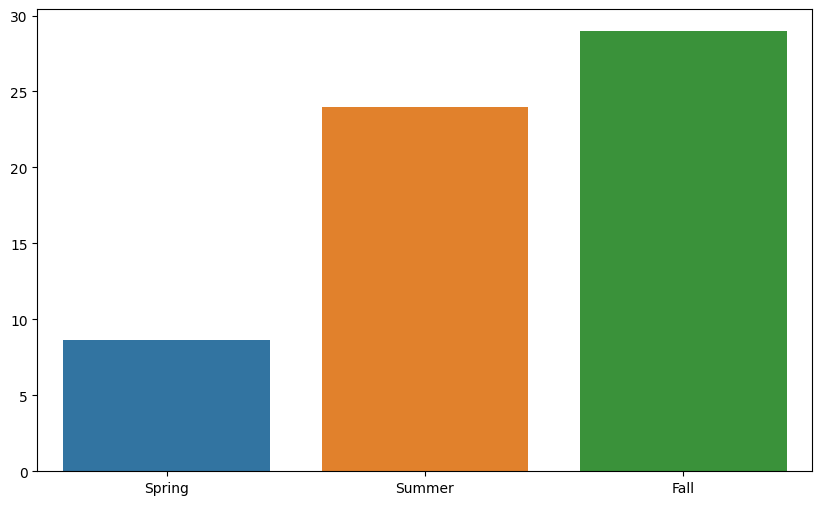

In [38]:
# create series that group the mean temperature per season
temp_spring = bike_df.groupby('season_spring')['temp_max'].mean().rename({1: 'Spring'})
temp_summer = bike_df.groupby('season_summer')['temp_max'].mean().rename({1:'Summer'})
temp_fall = bike_df.groupby('season_fall')['temp_max'].mean().rename({1:'Fall'})

# add them to one series and drop the rows with index 0
temp_seasons = temp_spring.append(temp_summer).append(temp_fall)
temp_seasons.drop(labels=[0], inplace=True)

#plot average temp_max per season
plt.figure(figsize=[10,6])
sb.barplot(x=temp_seasons.index, y=temp_seasons.values)

In [39]:
# create series that groups average users per season
cust_spring= bike_df.groupby('season_spring')['total_cust'].mean().rename({1:'Spring'})
cust_summer= bike_df.groupby('season_summer')['total_cust'].mean().rename({1:'Summer'})
cust_fall = bike_df.groupby('season_fall')['total_cust'].mean().rename({1:'Fall'})

# add them to on series and drop the rows with index 0
cust_seasons = cust_spring.append(cust_summer).append(cust_fall)
cust_seasons.drop(labels=[0], inplace=True)

/tmp/ipykernel_2652/3926754679.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cust_seasons = cust_spring.append(cust_summer).append(cust_fall)
/tmp/ipykernel_2652/3926754679.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cust_seasons = cust_spring.append(cust_summer).append(cust_fall)


<Figure size 1500x700 with 0 Axes>

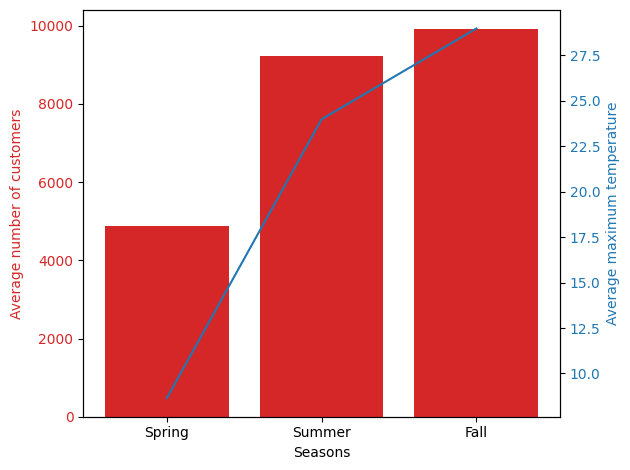

In [40]:
# assign x, y1 and y2
x = list(temp_seasons.index)
y1 = cust_seasons.values
y2 = temp_seasons.values

#from https://matplotlib.org/gallery/api/two_scales.html
# create3 plot containing both average counts of customers and average temp per month
plt.figure(figsize=[15,7])
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()   # instantiantes a second axes that share the same x-axis

color1 = 'tab:red'
ax1.set_xlabel('Seasons')
ax1.set_ylabel('Average number of customers', color=color1)
ax1.bar(x, y1, color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

color2 = 'tab:blue'
ax2.set_ylabel('Average maximum temperature', color=color2)
ax2.plot(x, y2, color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

fig.tight_layout()
plt.show()

Text(0.5, 1.0, 'Maximum temperature vs. number of customers')

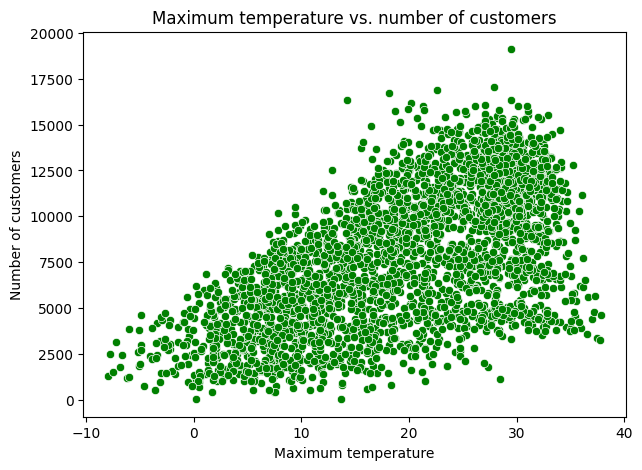

In [41]:
# plotting temp feature agains the target label total_cust
plt.figure(figsize=[7,5])
sb.scatterplot(data = bike_df, x='temp_max', y='total_cust', color='green')
plt.xlabel('Maximum temperature')
plt.ylabel('Number of customers')
plt.title('Maximum temperature vs. number of customers')

/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


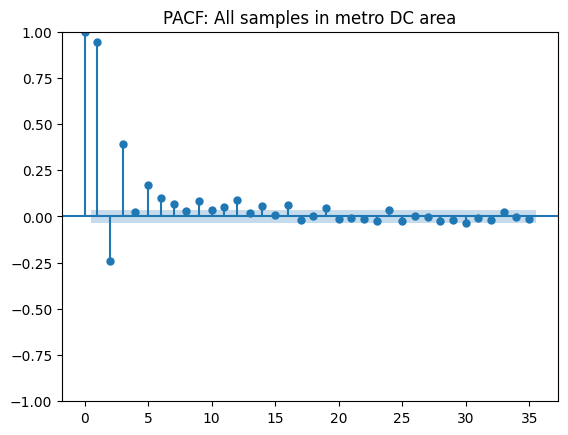

In [42]:
# partial autocorrelation of temp_max
plot_pacf(bike_df['temp_max'], title='PACF: All samples in metro DC area',)
plt.show()

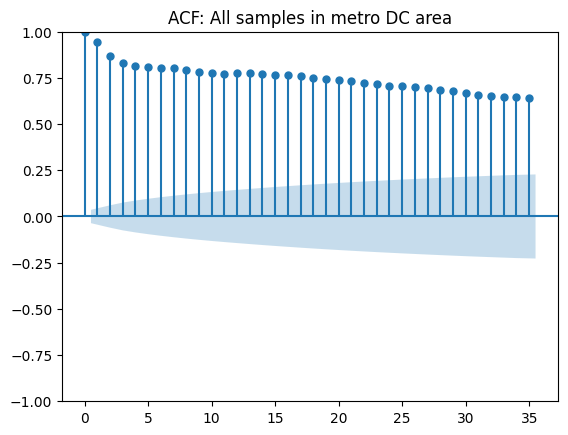

In [43]:
# autocorreleation of temp_max
plot_acf(bike_df['temp_max'], title='ACF: All samples in metro DC area',)
plt.show()

In [44]:
# optimal window for rolling std for temp_max
print(best_window_std(bike_df['temp_max'], bike_df['total_cust'], 30))

# correlation for window size determined by temp_max
temp_mean = bike_df['temp_max'].rolling(8).std()[7:-1]
pearsonr(temp_mean, bike_df['total_cust'][8:])

{1: -0.14741062385066672, 21: -0.27608100636622823}


PearsonRResult(statistic=-0.22323589445416725, pvalue=3.119764870939802e-34)

In [45]:
# optimal window for rolling mean for temperature
best_window(bike_df['temp_max'], bike_df['total_cust'], 30)

{16: 0.558195538335907, 29: 0.540475143240248}

Text(0.5, 0, 'Time')

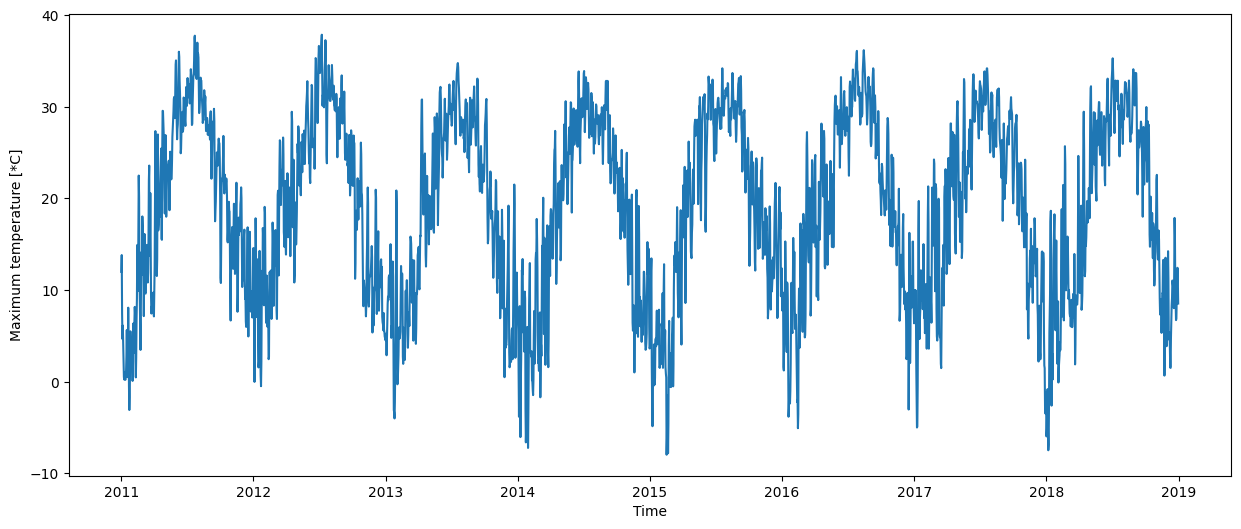

In [46]:
# plot the overall temp_max values for entire timeseries
plt.figure(figsize=[15,6])
ax= sb.lineplot(x='date_datetime', y='temp_max', data=bike_df)
plt.ylabel('Maximum temperature [*C]')
plt.xlabel('Time')

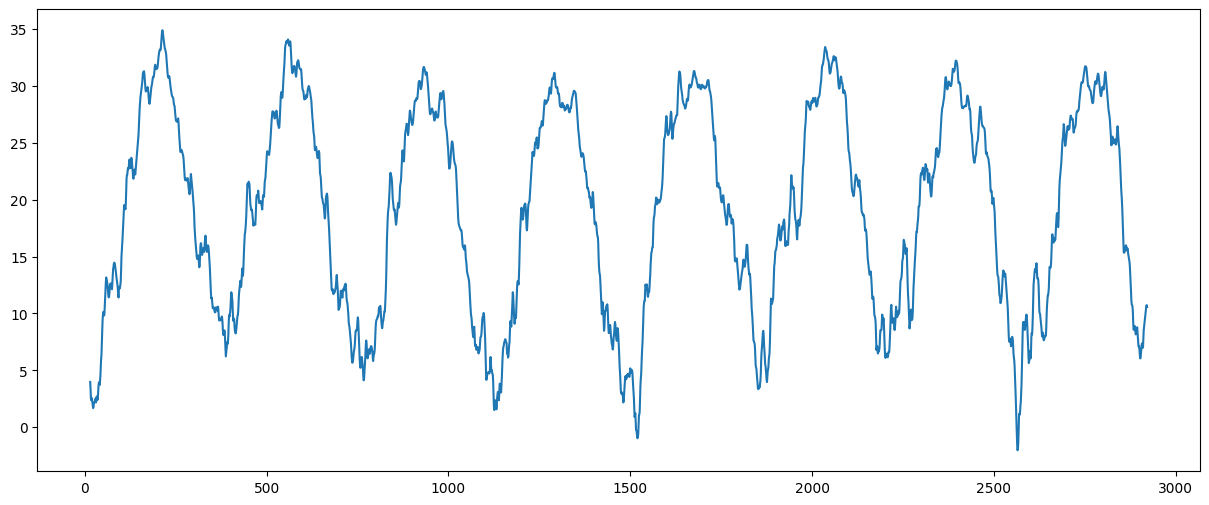

In [47]:
# plot of rolling means -- max temperatures
plt.figure(figsize=[15,6])
plt.plot(bike_df['temp_max'].rolling(16).mean())

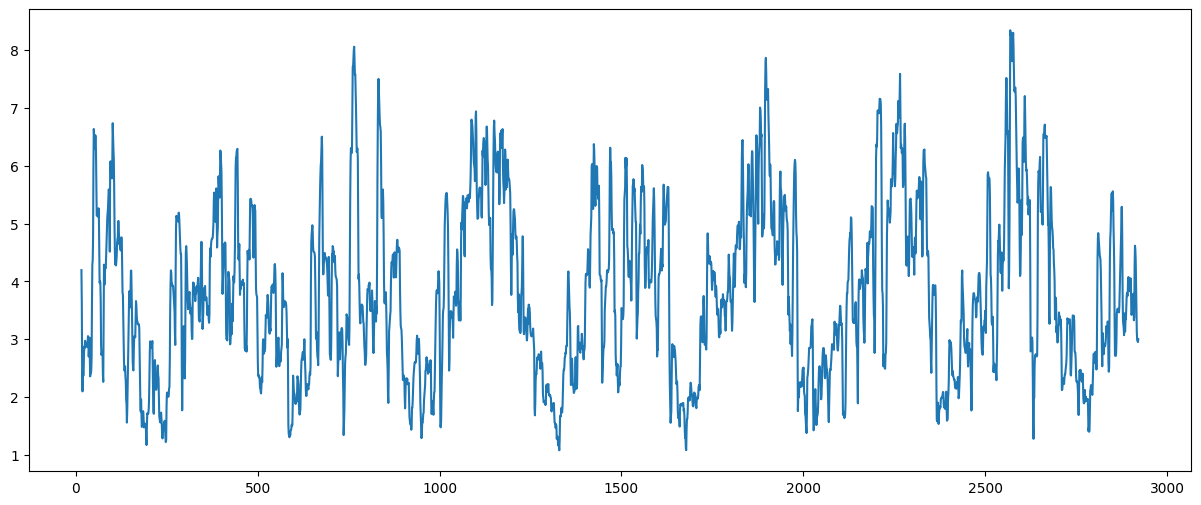

In [48]:
# plot of rolling stds -- max temperatures
plt.figure(figsize=[15,6])
plt.plot(bike_df['temp_max'].rolling(16).std())

Text(0.5, 1.0, 'Minimum temperature vs. number of customers')

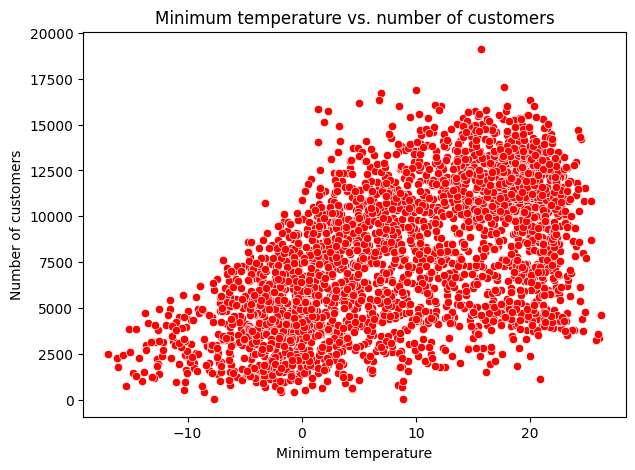

In [49]:
# plotting temp_min feature against the target label
plt.figure(figsize=[7,5])
sb.scatterplot(data=bike_df, x='temp_min', y='total_cust', color='red')
plt.xlabel('Minimum temperature')
plt.ylabel('Number of customers')
plt.title('Minimum temperature vs. number of customers')

In [50]:
# engineer new categorical temp features
bike_df_cat = bike_df.copy()
bike_df_cat['very_cold'] = bike_df_cat['temp_max'].apply(lambda x: 1 if x < 0 else 0)
bike_df_cat['cold'] = bike_df_cat['temp_max'].apply(lambda x: 1 if x < 10 and x >=0 else 0)
bike_df_cat['cool'] = bike_df_cat['temp_max'].apply(lambda x: 1 if x < 20 and x >= 10 else 0)
bike_df_cat['warm'] = bike_df_cat['temp_max'].apply(lambda x: 1 if x < 30 and x >= 20 else 0)
bike_df_cat['hot'] = bike_df_cat['temp_max'].apply(lambda x: 1 if x >= 30 else 0)

bike_df_cat[['very_cold', 'cold', 'cool', 'warm', 'hot']] = bike_df_cat[['very_cold', 'cold', 'cool', 'warm', 'hot']].shift()
bike_df_cat = bike_df_cat.iloc[1:,:]

pearsonr(bike_df_cat['total_cust'], bike_df_cat['cold'])

PearsonRResult(statistic=-0.4015910826314985, pvalue=1.222420256024716e-113)

Text(0, 0.5, 'Number of customers')

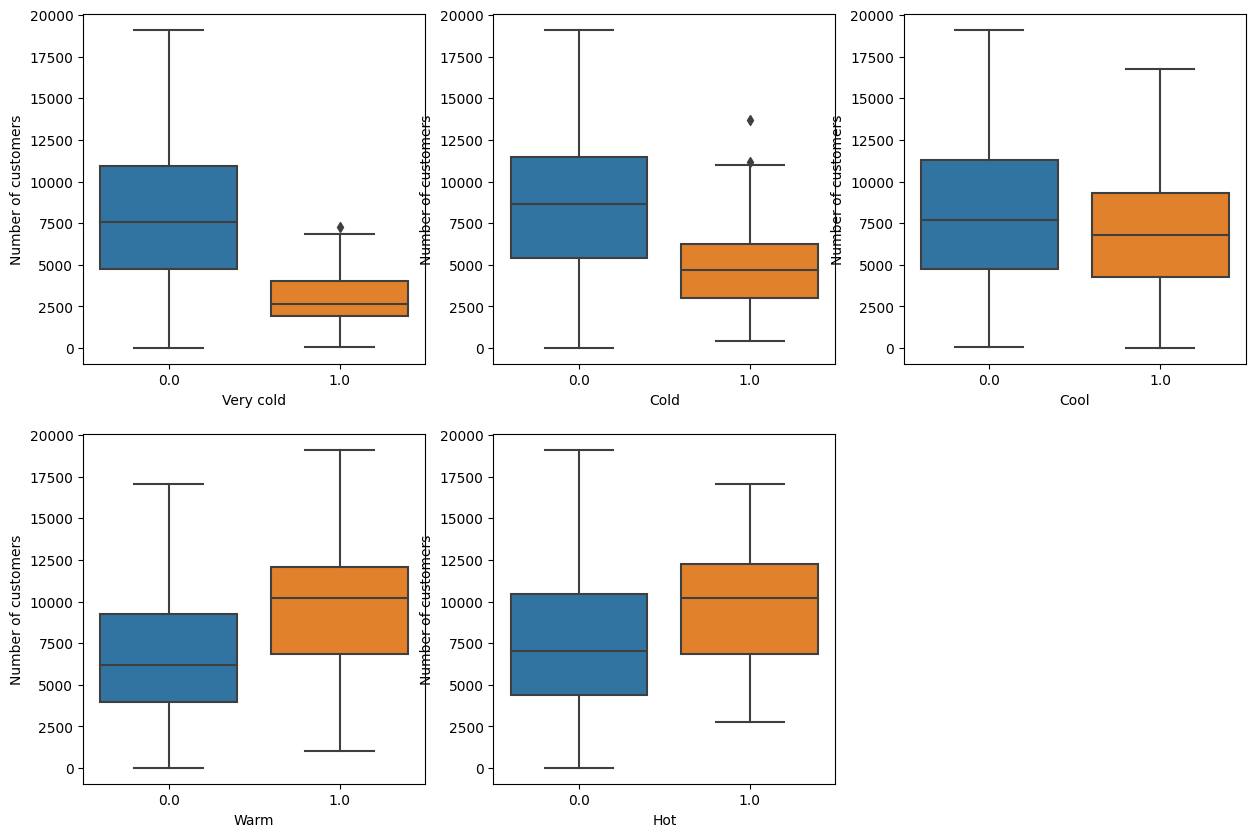

In [51]:
#plot categorized temperature
plt.figure(figsize=[15,10])
plt.subplot(2,3,1)
sb.boxplot(x = bike_df_cat['very_cold'], y = bike_df_cat['total_cust'])
plt.xlabel('Very cold')
plt.ylabel('Number of customers')

plt.subplot(2,3,2)
sb.boxplot(x = bike_df_cat['cold'], y = bike_df_cat['total_cust'])
plt.xlabel('Cold')
plt.ylabel('Number of customers')

plt.subplot(2,3,3)
sb.boxplot(x = bike_df_cat['cool'], y = bike_df_cat['total_cust'])
plt.xlabel('Cool')
plt.ylabel('Number of customers')

plt.subplot(2,3,4)
sb.boxplot(x = bike_df_cat['warm'], y = bike_df_cat['total_cust'])
plt.xlabel('Warm')
plt.ylabel('Number of customers')

plt.subplot(2,3,5)
sb.boxplot(x = bike_df_cat['hot'], y = bike_df_cat['total_cust'])
plt.xlabel('Hot')
plt.ylabel('Number of customers')

Text(0.5, 1.0, 'Precipitation vs. number of customers')

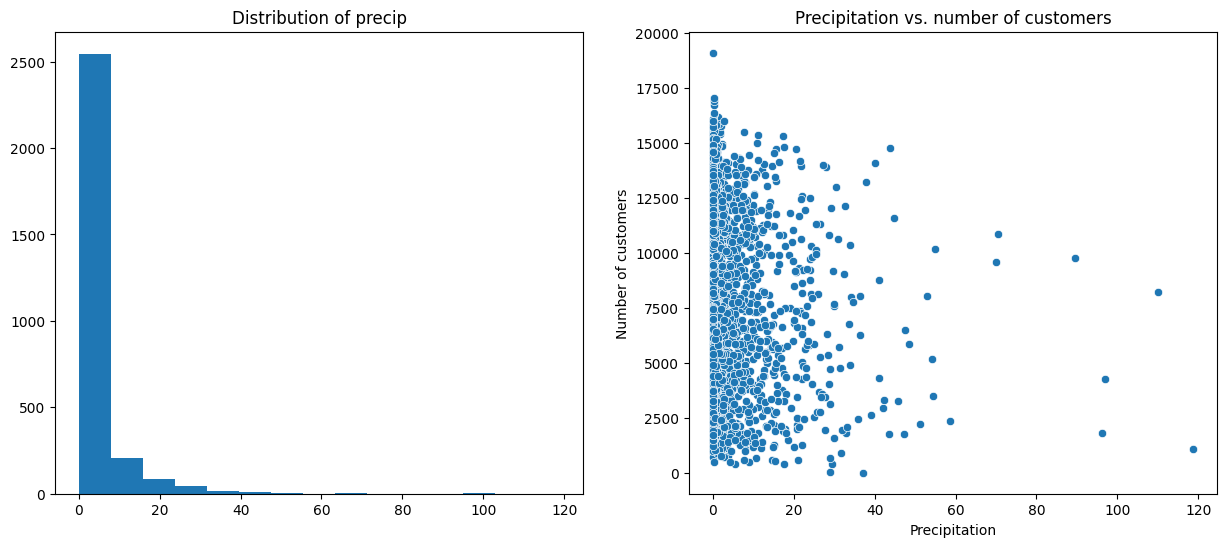

In [52]:
# plotting the distribution of precip
plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
plt.hist(bike_df['precip'], bins = 15)
plt.title('Distribution of precip')

plt.subplot(1,2,2)
sb.scatterplot(data = bike_df, x = 'precip', y = 'total_cust')
plt.xlabel('Precipitation')
plt.ylabel('Number of customers')
plt.title('Precipitation vs. number of customers')

Text(0.5, 1.0, 'Distribution of precip')

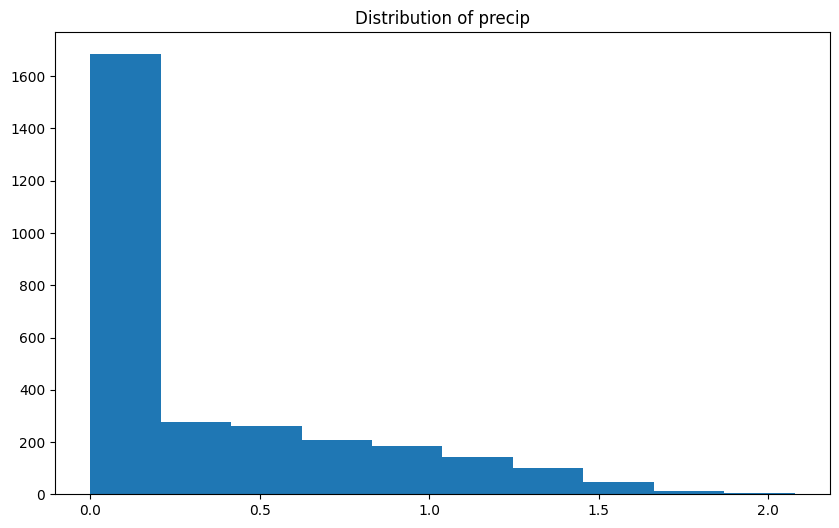

In [53]:
# distribution of precip
plt.figure(figsize=[10,6])
x=np.log10(bike_df['precip'] + 1)
plt.hist(x)
plt.title('Distribution of precip')

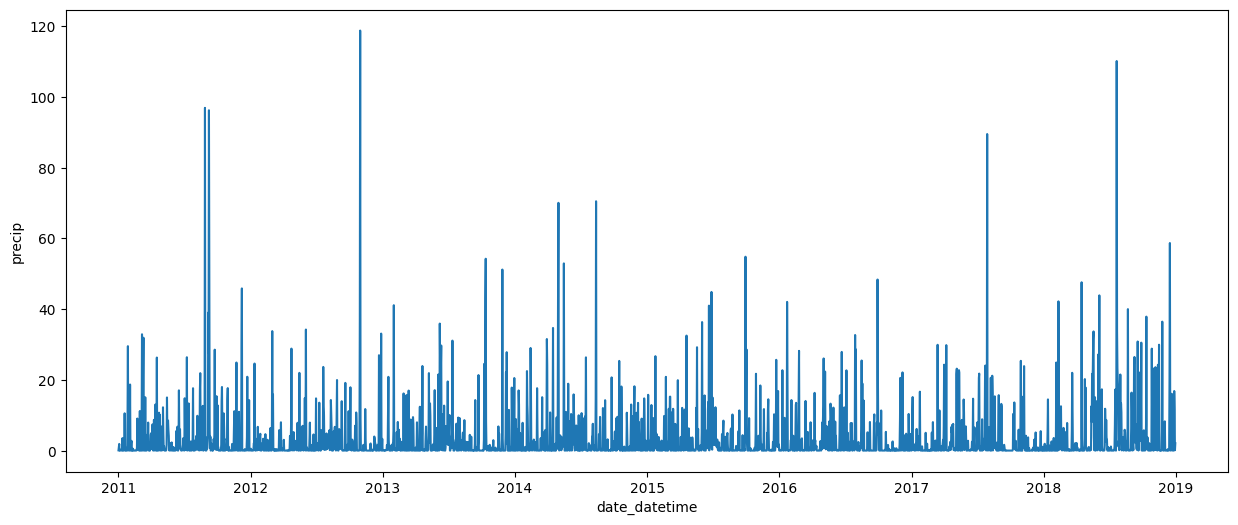

In [54]:
# plot the overall precip values for entire timeseries
plt.figure(figsize=[15,6])
ax = sb.lineplot(x='date_datetime', y='precip', data=bike_df)

In [55]:
# get the optimal number for rolling mean window
print(best_window(bike_df['precip'], bike_df['total_cust'], 30))

# correlation for window size determined by precip
precip_mean = bike_df['precip'].rolling(8).mean()[7:-1]
pearsonr(precip_mean, bike_df['total_cust'][8:])

{29: 0.1700866307778595, 1: 0.008462868123957596}


PearsonRResult(statistic=0.08720391472567389, pvalue=2.4247240767198335e-06)

In [56]:
# optimal window for rolling std for precip
print(best_window_std(bike_df['precip'], bike_df['total_cust'], 30))

# correlation for window size determined by precip
precip_mean = bike_df['precip'].rolling(8).std()[7:-1]
pearsonr(precip_mean, bike_df['total_cust'][8:])

{28: 0.08728613813774178, 1: -0.004316064962443652}


PearsonRResult(statistic=0.036881523719282605, pvalue=0.04650923284270452)

/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<function matplotlib.pyplot.show(close=None, block=None)>

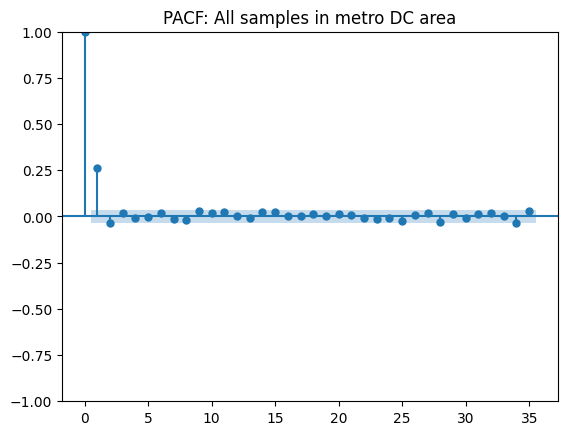

In [57]:
# plot the partial autocorrelation -- precip
plot_pacf(bike_df['precip'], title='PACF: All samples in metro DC area',)
plt.show

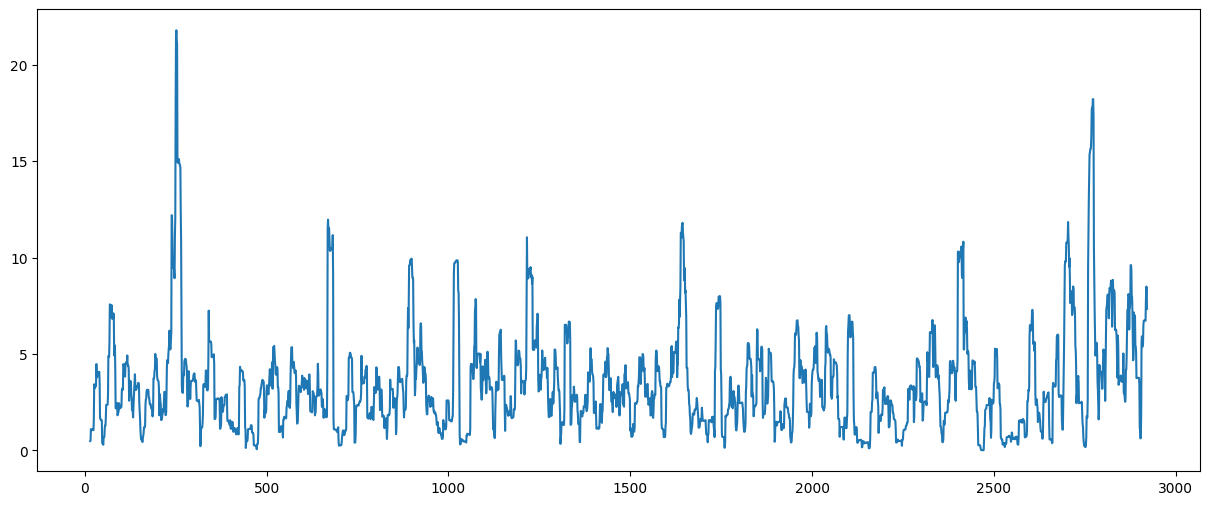

In [58]:
# plot of rolling means -- precipitation
plt.figure(figsize=[15,6])
plt.plot(bike_df['precip'].rolling(16).mean())

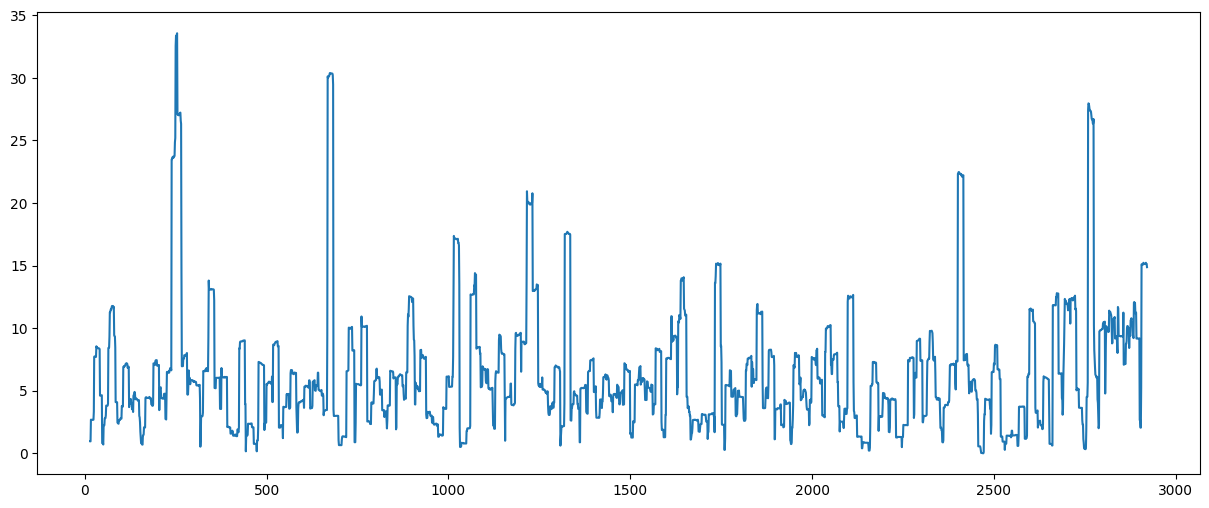

In [59]:
# plot of rolling stds -- precipitation
plt.figure(figsize=[15,6])
plt.plot(bike_df['precip'].rolling(16).std())

Text(0.5, 1.0, 'Wind vs. number of customers')

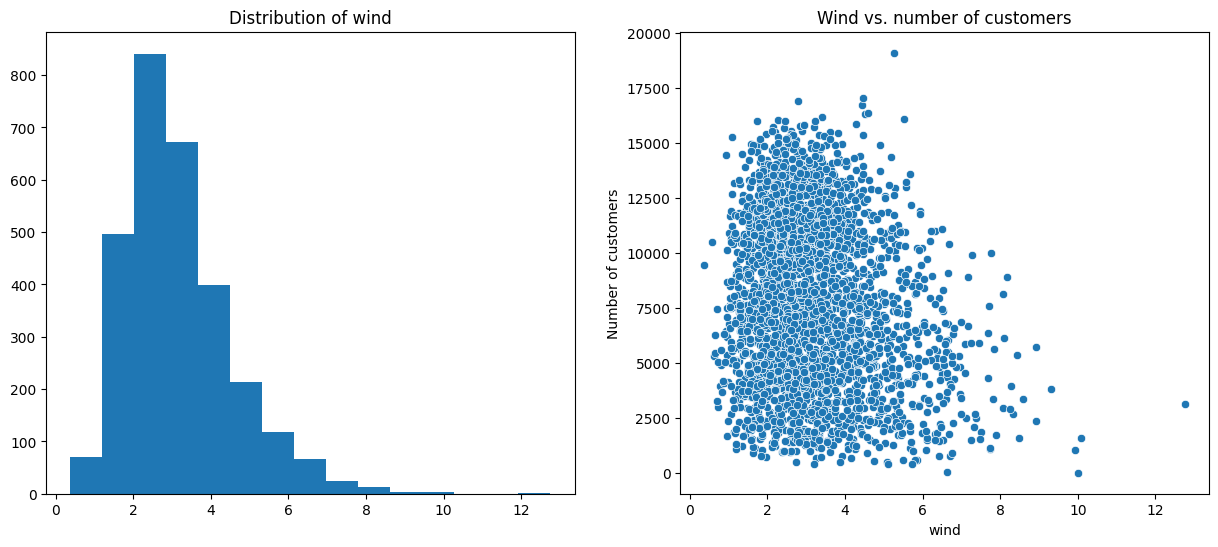

In [60]:
# plotting the distribution of wind
plt.figure(figsize=[15,6])

plt.subplot(1,2,1)
plt.hist(bike_df['wind'], bins=15)
plt.title('Distribution of wind')

plt.subplot(1,2,2)
sb.scatterplot(data = bike_df, x='wind', y='total_cust')
plt.xlabel('wind')
plt.ylabel('Number of customers')
plt.title('Wind vs. number of customers')

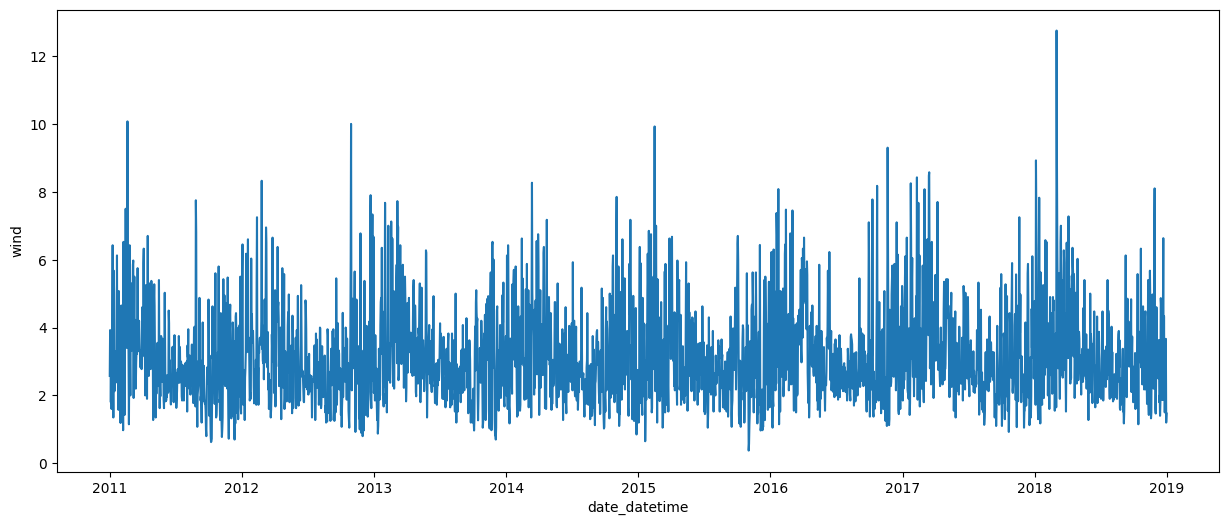

In [61]:
# plot the overall wind values for entire timeseries
plt.figure(figsize=[15,6])
ax = sb.lineplot(x='date_datetime', y='wind', data=bike_df)

In [62]:
# optimal number for rollin mean window
print(best_window(bike_df['wind'], bike_df['total_cust'], 30))

# correlation for window size determined by wind
wind_mean = bike_df['wind'].rolling(8).mean()[7:-1]
pearsonr(wind_mean, bike_df['total_cust'][8:])[0]

{29: -0.12193904260296551, 4: -0.17329637853316024}


-0.16774099233635414

In [63]:
# optimal window for rolling std for temperature
print(best_window_std(bike_df['wind'], bike_df['total_cust'], 30))

# correlation for window size determined by wind
percip_mean = bike_df['wind'].rolling(8).std()[7:-1]
pearsonr(precip_mean, bike_df['total_cust'][8:])

{1: -0.2063792748349396, 28: -0.41986595132327353}


PearsonRResult(statistic=0.036881523719282605, pvalue=0.04650923284270452)

/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


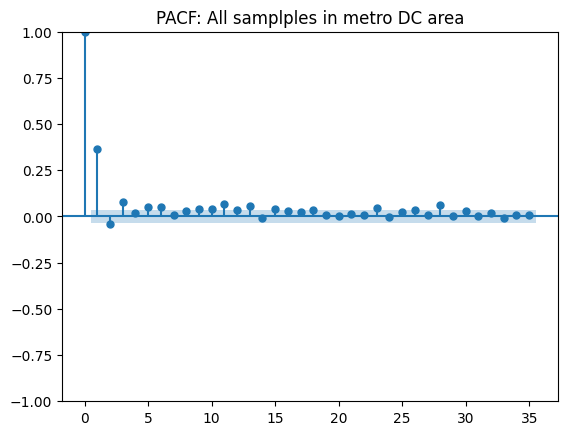

In [64]:
# plot the partial autocorrelation off wind
plot_pacf(bike_df['wind'], title='PACF: All samplples in metro DC area',)
plt.show()

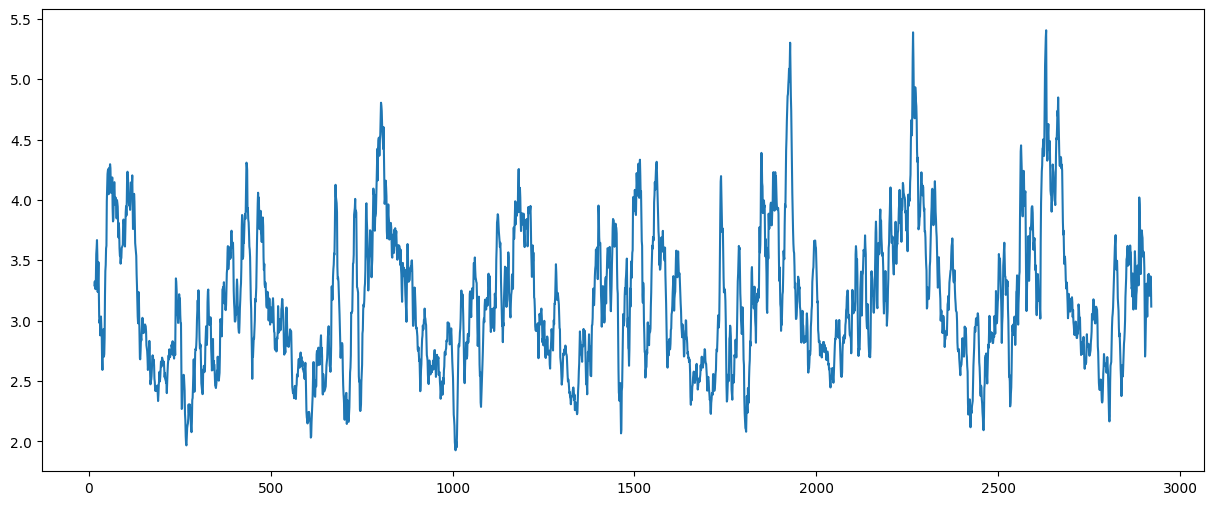

In [65]:
# plot of rolling means -- wind
plt.figure(figsize=[15,6])
plt.plot(bike_df['wind'].rolling(16).mean())

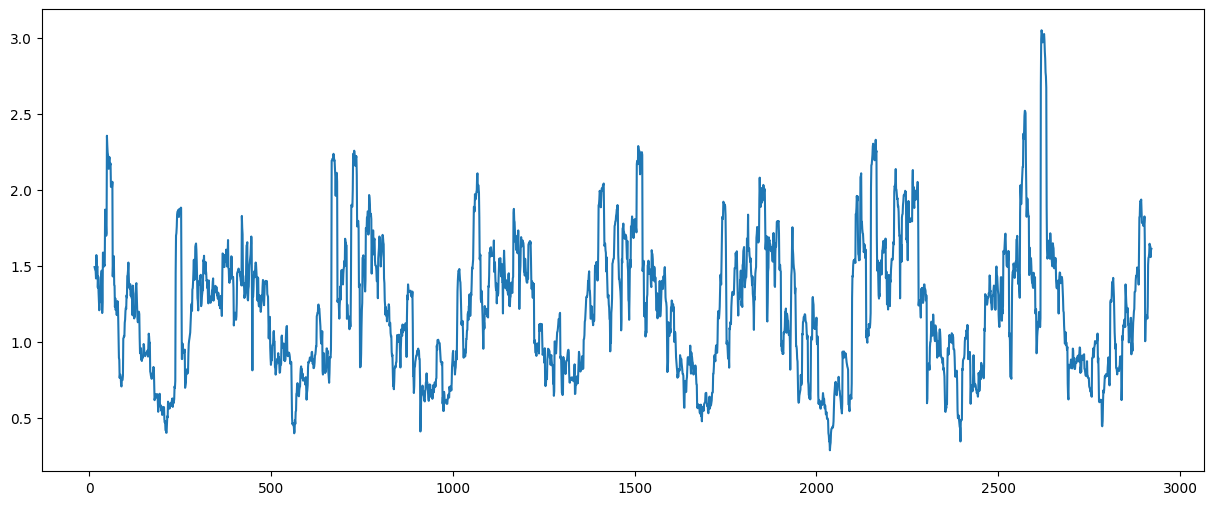

In [66]:
# plot of rolling stds -- wind
plt.figure(figsize=[15,6])
plt.plot(bike_df['wind'].rolling(16).std())

## Checking and dealing with stationarity

In [67]:
# from https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/
# Augmented Dickey Fuller Test

def adf_test(df, col_names):
    for name in col_names:
        print('Results of Augmented Dickey-Fuller Test for {}'.format(name))
        result_test = adfuller(df[name], autolag='AIC')
        result_output = pd.Series(result_test[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
        for key, val in result_test[4].items():
            result_output['Critical Value (%s)'%key] = val
        print(result_output)

In [68]:
# create the feature that need to be tested
# total_cust_t-1 was already added to the dataframe
testing_feat = ['wind', 'precip', 'total_cust', 'temp_min', 'temp_max', 'foggy', 'ice', 'thunder','sleet']
testing_df = pd.DataFrame()

for col in testing_feat:
    col_mean = bike_df[col].rolling(16).mean()[15:-1]
    col_std = bike_df[col].rolling(16).std()[15:-1]
    testing_df[col+'_mean16'] = col_mean.values
    testing_df[col+'_std16'] = col_std.values

In [69]:
# adf test for total_cust_t-1
temp_cust_1 = bike_df['total_cust_t-1'].fillna(0)
bike_df_temp = pd.DataFrame(temp_cust_1, columns=['total_cust_t-1'])
adf_test(bike_df_temp, ['total_cust_t-1'])

Results of Augmented Dickey-Fuller Test for total_cust_t-1
Test Statistic                   -3.085391
p-value                           0.027653
#Lags Used                       22.000000
Number of Observations Used    2899.000000
Critical Value (1%)              -3.432608
Critical Value (5%)              -2.862538
Critical Value (10%)             -2.567301
dtype: float64


In [70]:
# adf test for total_cust
adf_test(bike_df, ['total_cust'])

Results of Augmented Dickey-Fuller Test for total_cust
Test Statistic                   -3.068277
p-value                           0.028992
#Lags Used                       22.000000
Number of Observations Used    2899.000000
Critical Value (1%)              -3.432608
Critical Value (5%)              -2.862538
Critical Value (10%)             -2.567301
dtype: float64


In [71]:
# adf test for all engineered features 
adf_test(testing_df, testing_df.columns)

Results of Augmented Dickey-Fuller Test for wind_mean16
Test Statistic                   -5.565211
p-value                           0.000002
#Lags Used                       28.000000
Number of Observations Used    2877.000000
Critical Value (1%)              -3.432625
Critical Value (5%)              -2.862545
Critical Value (10%)             -2.567305
dtype: float64
Results of Augmented Dickey-Fuller Test for wind_std16
Test Statistic                   -5.043268
p-value                           0.000018
#Lags Used                       17.000000
Number of Observations Used    2888.000000
Critical Value (1%)              -3.432616
Critical Value (5%)              -2.862541
Critical Value (10%)             -2.567303
dtype: float64
Results of Augmented Dickey-Fuller Test for precip_mean16
Test Statistic                -8.653592e+00
p-value                        5.038219e-14
#Lags Used                     2.700000e+01
Number of Observations Used    2.878000e+03
Critical Value (1%)    

## Kwiatkowski-Phillips-Schmidt-Shin Test  

In [72]:
# from https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/

def kpss_test(df, col_names):
    for name in col_names:
        print('Results of KPSS Test for {}'.format(name))
        result_test = kpss(df[name], regression='c', nlags='legacy')
        result_output = pd.Series(result_test[0:3], index=['Test Statistic', 'p-value', 'Lags Used'])
        for key, val in result_test[3].items():
            result_output['Critical Value (%s)' %key] = val
        print(result_output)

# kpss test for total cust
kpss_test(testing_df, testing_df.columns)

Results of KPSS Test for wind_mean16
Test Statistic            0.361757
p-value                   0.093639
Lags Used                28.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Results of KPSS Test for wind_std16
Test Statistic            0.066393
p-value                   0.100000
Lags Used                28.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Results of KPSS Test for precip_mean16
Test Statistic            0.190685
p-value                   0.100000
Lags Used                28.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Results of KPSS Test for precip_std16
Test Statistic            0.12816
p-value                   0.10000
La

/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test stati

In [73]:
# kpss test for total_cust_t-1
kpss_test(bike_df_temp, ['total_cust_t-1'])
# kpss test for total_cust
kpss_test(bike_df, ['total_cust'])

Results of KPSS Test for total_cust_t-1
Test Statistic            4.452604
p-value                   0.010000
Lags Used                28.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Results of KPSS Test for total_cust
Test Statistic            4.430839
p-value                   0.010000
Lags Used                28.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [74]:
# Removing positive upward trend from total_cust_mean, total_cust_std16 and total_cust_t-1
testing_df['total_cust_std16_log'] = [np.log1p(x+1) for x in testing_df['total_cust_std16']]
testing_df['total_cust_mean16_log'] = [np.log1p(x+1) for x in testing_df['total_cust_mean16']]
bike_df_temp['total_cust_t-1_log'] = [np.log1p(x+1) for x in bike_df_temp['total_cust_t-1']]


## Differencing

In [75]:
# applying differencing to remove trend from total_cust
bike_df_check = bike_df[['total_cust']]
bike_df_check['total_cust_diff'] = bike_df_check['total_cust'] - bike_df_check['total_cust'].shift()
bike_df_check = bike_df_check.iloc[1:,]

/tmp/ipykernel_2652/4231989867.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bike_df_check['total_cust_diff'] = bike_df_check['total_cust'] - bike_df_check['total_cust'].shift()


In [76]:
#  kpss test for total_cust
kpss_test(testing_df, ['total_cust_std16_log', 'total_cust_mean16_log'])
kpss_test(bike_df_temp, ['total_cust_t-1_log'])

# adf test for total_cust
adf_test(testing_df, ['total_cust_std16_log', 'total_cust_mean16_log'])
adf_test(bike_df_temp, ['total_cust_t-1_log'])
adf_test(bike_df_check, ['total_cust_diff'])

Results of KPSS Test for total_cust_std16_log
Test Statistic            6.328651
p-value                   0.010000
Lags Used                28.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Results of KPSS Test for total_cust_mean16_log
Test Statistic            4.412647
p-value                   0.010000
Lags Used                28.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Results of KPSS Test for total_cust_t-1_log
Test Statistic            4.013791
p-value                   0.010000
Lags Used                28.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Results of Augmented Dickey-Fuller Test for total_cust_std16_log


/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Test Statistic                   -4.578370
p-value                           0.000142
#Lags Used                       16.000000
Number of Observations Used    2889.000000
Critical Value (1%)              -3.432616
Critical Value (5%)              -2.862541
Critical Value (10%)             -2.567303
dtype: float64
Results of Augmented Dickey-Fuller Test for total_cust_mean16_log
Test Statistic                   -3.959044
p-value                           0.001641
#Lags Used                       28.000000
Number of Observations Used    2877.000000
Critical Value (1%)              -3.432625
Critical Value (5%)              -2.862545
Critical Value (10%)             -2.567305
dtype: float64
Results of Augmented Dickey-Fuller Test for total_cust_t-1_log
Test Statistic                   -3.902610
p-value                           0.002016
#Lags Used                       26.000000
Number of Observations Used    2895.000000
Critical Value (1%)              -3.432611
Critical Value (5%)     

## 2.6 Feature Selection
Based on above EDA the following features will be included in the model

    holiday: t0
    weekdays: each day at t0
    workingday: t0
    temp_max: rolling mean for 8 
    temp_max: rolling std for 8 days
    temp_min:rolling mean for 8 days
    temp_min: rolling std for 8 days
    season_spring: t0
    season_summer: t0
    season_fall: t0
    very cold, cold, cool, warm, hot: t-1
    foggy, thunder, ice, sleet: rolling mean and std for 8 days
    wind: rolling mean for 8 days
    wind: rolling std for 8 days
    precip: rolling mean for 8 days
    precip: rolling std for 8 days
    total_cust: t-1
    total_cust: rolling mean for 8 days
    total_cust: rolling std for 8 days


## 3. Data Preparation

In [77]:
# Dropping unnecessary columns
# shoudl keep this before the  cleaning function has been created
bike_df.drop(columns=['temp_observ', 'weekday'], axis=1, inplace=True)
# drop the timestamp variable
bike_df.drop(columns=['date_datetime'], inplace=True)

In [78]:
# 3.2 Creating new features
# specify the window for rolling values
window = 8

# engineer new categorical temp features
bike_df_cat = bike_df[['temp_max']].copy()
bike_df_cat['very_cold'] = bike_df_cat['temp_max'].apply(lambda x: 1 if x < 0 else 0)
bike_df_cat['cold'] = bike_df_cat['temp_max'].apply(lambda x: 1 if x < 10 and x >= 0 else 0)
bike_df_cat['cool'] = bike_df_cat['temp_max'].apply(lambda x: 1 if x < 20 and x >= 10 else 0)
bike_df_cat['warm'] = bike_df_cat['temp_max'].apply(lambda x: 1 if x < 30 and x >= 20 else 0)
bike_df_cat['hot'] = bike_df_cat['temp_max'].apply(lambda x: 1 if x >= 30 else 0)

bike_df_cat[['very_cold', 'cold', 'cool', 'warm', 'hot']] = bike_df_cat[['very_cold', 'cold', 'cool', 'warm', 'hot']].shift()
bike_df_cat.drop(columns=['temp_max'], inplace=True)

# creating rolling values
new_feat = ['wind', 'precip', 'total_cust', 'temp_max', 'temp_min', 'foggy', 'ice', 'thunder','sleet']
temp_df = pd.DataFrame()

for col in new_feat:
    col_mean = bike_df[col].rolling(window).mean()[(window-1):-1]
    col_std = bike_df[col].rolling(window).std()[(window-1):-1]
    temp_df[col + '_mean'+str(window)] = col_mean.values
    temp_df[col+'_std'+str(window)] = col_std.values

# remove the first row from 16 rows from total_cust (target label)
new_bike_df = bike_df.iloc[window:, :]
bike_df_cat = bike_df_cat.iloc[window:,:]
new_bike_df.reset_index(drop=True, inplace=True)
bike_df_cat.reset_index(drop=True, inplace=True)
new_bike_df.head()

,temp_min,temp_max,precip,wind,total_cust,holiday,season_spring,season_summer,season_fall,weekday_1,...,weekday_3,weekday_4,weekday_5,weekday_6,working_day,foggy,thunder,ice,sleet,total_cust_t-1
0,-6.293333,0.226667,0.283529,6.425,802.0,0.0,1,0,0,0,...,0,0,0,1,0.0,1,0.0,0,0,939.0
1,-6.238462,0.507692,0.000000,2.975,1298.0,0.0,1,0,0,0,...,0,0,0,0,0.0,1,0.0,0,0,802.0
2,-5.914286,0.564286,0.460241,1.350,1231.0,0.0,1,0,0,1,...,0,0,0,0,1.0,1,0.0,1,1,1298.0
3,-5.114286,0.192857,3.526882,5.675,1141.0,0.0,1,0,0,0,...,0,0,0,0,1.0,1,0.0,0,1,1231.0
4,-4.600000,1.035714,0.000000,5.025,1383.0,0.0,1,0,0,0,...,1,0,0,0,1.0,1,0.0,0,0,1141.0


In [79]:
# drop all columns which we cannot use because of lookahead bias
new_bike_df.drop(columns=['temp_max', 'wind', 'temp_min', 'precip', 'thunder', 'foggy', 'ice', 'sleet'], inplace=True)

# merging both dataframes with features
final_bike_df = new_bike_df.join(temp_df, how='left')
final_bike_df = final_bike_df.join(bike_df_cat, how='left')
final_bike_df.head()

/tmp/ipykernel_2652/3879898264.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_bike_df.drop(columns=['temp_max', 'wind', 'temp_min', 'precip', 'thunder', 'foggy', 'ice', 'sleet'], inplace=True)


,total_cust,holiday,season_spring,season_summer,season_fall,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,...,ice_std8,thunder_mean8,thunder_std8,sleet_mean8,sleet_std8,very_cold,cold,cool,warm,hot
0,802.0,0.0,1,0,0,0,0,0,0,0,...,0.353553,0.0,0.0,0.375,0.517549,0.0,1.0,0.0,0.0,0.0
1,1298.0,0.0,1,0,0,0,0,0,0,0,...,0.353553,0.0,0.0,0.375,0.517549,0.0,1.0,0.0,0.0,0.0
2,1231.0,0.0,1,0,0,1,0,0,0,0,...,0.353553,0.0,0.0,0.375,0.517549,0.0,1.0,0.0,0.0,0.0
3,1141.0,0.0,1,0,0,0,1,0,0,0,...,0.462910,0.0,0.0,0.500,0.534522,0.0,1.0,0.0,0.0,0.0
4,1383.0,0.0,1,0,0,0,0,1,0,0,...,0.462910,0.0,0.0,0.625,0.517549,0.0,1.0,0.0,0.0,0.0


In [82]:
# 3.3 Assigning X and y
y = final_bike_df['total_cust']
X = final_bike_df.drop(columns=['total_cust'])

## 4. Model

In [87]:
# creating transformation classes
class Debug(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        self.shape = X.shape
        print(self.shape)
        X_df = pd.DataFrame(X)
        print(X_df)
        #  print(X_df.to_string())  # can only be print like this withour running LagVars() to avoid crash
        # what other output you want
        return X

# 4.2 Baseline model: naive univariate prediction
# assigning X and y for the univariate naive prediction
y_naive = (final_bike_df['total_cust'].copy())
X_naive = y_naive.copy()
X_naive = pd.DataFrame(data=X_naive, columns=['total_cust'])

# getting the start time
start_time = datetime.now()

# creating y_pred
y_pred = (X_naive.shift())[1:]
# adjusting length of the actual target values
y_naive = y_naive[1:]

# get  final time
end_time = datetime.now()
print('Total running time of naive predictor:', (end_time - start_time).total_seconds())

# calculating the scorees for the last value method
print('RMS:', np.sqrt(mean_squared_error(y_naive, y_pred)))
print('RMSLE:', np.sqrt(mean_squared_log_error(y_naive, y_pred)))
print('MAE:', mean_absolute_error(y_naive, y_pred))


Total running time of naive predictor: 0.000317
RMS: 2092.6809614099934
RMSLE: 0.40731742102103863
MAE: 1403.2437349811191


In [101]:
# preparation code -- using differenced y for predictions
y_log = final_bike_df[['total_cust']].copy()
y_log['total_cust'] = y_log['total_cust'].apply(lambda x: np.log1p(x+1))
y_shift = y_log.shift(1)
y_diff = (y_log - y_shift)[1:]
X_diff = X[1:]

y_diff.reset_index(drop=True, inplace =True)
X_diff.reset_index(drop=True, inplace=True)

# initializing Random Forest model using default hyperparameters
model_rf_diff = RandomForestRegressor(random_state=42)

# creating and fitting the ML pipeline
trend_features = ['total_cust_mean' + str(window), 'total_cust_std'+str(window), 'total_cust_t-1']
preprocessor = ColumnTransformer([('trend_diff', FunctionTransformer(np.log1p, validate=False),trend_features),], remainder='passthrough')
pipeline = Pipeline([('preprocessor', preprocessor),('model', model_rf_diff)]) #('debug', Debug()) # not included, it hinder the execution of this pipeline
pipeline_rf_diff = pipeline.fit(X_diff, y_diff)

# creating a timeseries split of the dataset
time_split = TimeSeriesSplit(n_splits=10)

# cross validation of splits and score calculation
scores_rf_diff = cross_validate(pipeline_rf_diff, X_diff, y_diff, cv=time_split, scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'], return_train_score=True, n_jobs=-1)

# root mean squared error
print('Average RMSE train data:', sum([np.sqrt(-1 * x) for x in scores_rf_diff['train_neg_mean_squared_error']])/len(scores_rf_diff['train_neg_mean_squared_error']))
print('Average RMSE test data:', sum([np.sqrt(-1 * x) for x in scores_rf_diff['test_neg_mean_squared_error']])/len(scores_rf_diff['test_neg_mean_squared_error']))

# mean absolut error
print('Average MAE train data:', sum([(-1 * x) for x in scores_rf_diff['train_neg_mean_absolute_error']])/len(scores_rf_diff['train_neg_mean_absolute_error']))
print('Average MAE test data:', sum([(-1 * x) for x in scores_rf_diff['test_neg_mean_absolute_error']])/len(scores_rf_diff['test_neg_mean_absolute_error']))


/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/hades/codeProj/bikeProj/.bikeEnv/lib/python3.10/site-packages/sklearn/pip

Average RMSE train data: 0.13254412204057067
Average RMSE test data: 0.3877538755135256
Average MAE train data: 0.07924185931103389
Average MAE test data: 0.27507221596449083


In [104]:
# getting indices for all folds from timeseries split
X_train_over = defaultdict()
X_test_over = defaultdict()
y_train_over = defaultdict()
y_test_over = defaultdict()

y_test_index = []
y_train_index = []

count = 0

for train_index, test_index in time_split.split(X_diff):
    print('TRAIN:', train_index, 'TEST:', test_index)

    y_test_index.append(test_index)
    y_train_index.append(train_index)

    X_train, X_test = X_diff.iloc[train_index], X_diff.iloc[test_index]
    y_train, y_test = (np.array(y_diff))[train_index], (np.array(y_diff))[test_index]
    X_train_over[count] = X_train
    X_test_over[count] = X_test
    y_train_over[count] = y_train
    y_test_over[count] = y_test

    count += 1



TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244

In [106]:
def split_pred_test(X_train, y_train, X_test, y_test, split):
    pipeline_part = pipeline.fit(X_train[split], y_train[split].ravel())
    prediction_test = pipeline_part.predict(X_test[split])
    #print('transformedRMSE:', np.sqrt(mean_squared_error(y_test[split], prediction_test)))

    # what are the predictions in absolute terms
    y_test_pred_log = prediction_test + y_log.iloc[y_test_index[split]]['total_cust']
    y_test_pred = np.exp(y_test_pred_log) - 2

    # what are the actual values in absolute terms
    y_test_true_log  = y_test[split] + y_log.iloc[y_test_index[split]]
    y_test_true = np.exp(y_test_true_log) - 2  # minus 2 because we added 1 each when doing the e log function earlier

    # what is the RMSE, RMSLE and MAE
    #print('actual RMSE:', np.sqrt(mean_squared_error(y_test_true, y_test_pred)))
    #print('actual RMSLE:', np.sqrt(mean_squared_log_error(y_test_true, y_test_pred)))
    #print('actual MAE:', mean_absolute_error(y_test_true, y_test_pred))

    rmse = np.ssqrt(mean_squared_error(y_test_true, y_test_pred))
    rmsle = np.sqrt(mean_squared_log_error(y_test_true, y_test_pred))
    mae = mean_absolute_error(y_test_true, y_test_pred)

    list_scores = []
    list_scores.extend([rmse, rmsle, mae])

    return list_scores

    

def split_predict_train(X_train, y_train, X_test, y_test, split):
    
    pipeline_part = pipeline.fit(X_train[split], y_train[split].ravel())
    prediction_train = pipeline_part.predict(X_train[split])
    #print('transformed RMSE:', np.sqrt(mean_squared_error(y_test[split], prediction_test)))
        
    # what are the predictions in absolute terms
    y_train_pred_log = prediction_train + y_log.iloc[y_train_index[split]]['total_cust']
    y_train_pred = np.exp(y_train_pred_log) - 2

    # what are the actual values in absolute terms
    y_train_true_log = y_train[split] + y_log.iloc[y_train_index[split]]
    y_train_true = np.exp(y_train_true_log) - 2 # minus 2 because we added 1 each when doing the log function earlier

    # what is the rmse, rmsle and mae
    #print('actual RMSE:', np.sqrt(mean_squared_error(y_test_true, y_test_pred)))
    #print('actual RMSLE:', np.sqrt(mean_squared_log_error(y_test_true, y_test_pred)))
    #print('actual MAE:', mean_absolute_error(y_test_true, y_test_pred))
    
    rmse = np.sqrt(mean_squared_error(y_train_true, y_train_pred))
    rmsle = np.sqrt(mean_squared_log_error(y_train_true, y_train_pred))
    mae = mean_absolute_error(y_train_true, y_train_pred)
    
    list_scores = []
    list_scores.extend([rmse, rmsle, mae])
    
    return list_scores

In [ ]:
# 4.4 Random Forests
# model with untransformed y